# Рекомендательная система по премиум-танкам для игры Tanks Blitz

Суть проекта: предсказывать средний урон игрока на премиум танках основываясь на его статистике игры на обычных танках.

## Загрузка данных

Данные: датасет с информацией о танках и датасет с информацией о статистике игрока на каждом танке.  
В информации о статистике игрока имеются колонки:  
|Колонка|Значение|
| -------- | ------- |
|user_id|ID игрока|
|tank_id|ID танка|
|spotted|Количество обнаруженной техники|
|hits|Количество попаданий|
|frags|Количество уничтоженной техники|
|max_xp|Максимальный опыт за бой|
|wins|Количество побед|
|losses|Количество поражений|
|capture_points|Очки захвата базы|
|battles|Количество боёв|
|damage_dealt|Нанесённый урон|
|damage_received|Полученный урон|
|max_frags|Максимум уничтожено за бой|
|shots|Произведено выстрелов|
|frags8p|Количество уничтоженной техники (уровень >=8)|
|xp|Суммарный опыт|
|win_and_survived|Выжил в боях и победил|
|survived_battles|Выжил в боях|
|dropped_capture_points|Очки защиты базы|
|battle_life_time|Общее время в боях в секундах|
|mark_of_mastery|Знаки классности:<br>— 0 — Отсутствует<br>— 1 — 3 степень<br>— 2 — 2 степень<br>— 3 — 1 степень<br>— 4 — Мастер|

In [1]:
import gc
import os
import warnings

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from flaml import AutoML
from loguru import logger
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
premium_df = pd.read_csv("../data/premium_tanks.csv")
premium_df.head()

,tank_id,nation,tier,type,name,default_profile.firepower,default_profile.hp,default_profile.hull_hp,default_profile.hull_weight,default_profile.maneuverability,...,default_profile.gun.move_up_arc,default_profile.gun.reload_time,default_profile.gun.traverse_speed,default_profile.suspension.load_limit,default_profile.suspension.traverse_speed,default_profile.turret.hp,default_profile.turret.traverse_left_arc,default_profile.turret.traverse_right_arc,default_profile.turret.traverse_speed,default_profile.turret.view_range
0,3073,ussr,3,lightTank,Т-46,21,480,384,7800,72,...,16,9.00,43.75,17300,48,96,180,180,44,220
1,8049,other,5,mediumTank,Шип,30,650,496,12292,47,...,25,7.80,35.00,25000,33,154,180,180,40,240
2,63841,japan,5,mediumTank,Panzer IV Lightning,29,710,568,11270,48,...,20,8.04,35.00,28000,35,142,180,180,48,240
3,52513,usa,7,heavyTank,M6A2E1,47,1400,1120,36550,30,...,20,10.50,35.00,70500,25,280,180,180,25,250
4,6481,uk,4,lightTank,Covenanter,29,600,480,9510,50,...,20,10.00,43.75,20500,40,120,180,180,48,230


In [3]:
general_df = pd.read_csv("../data/general_tanks.csv")
general_df.head()

,tank_id,nation,tier,type,name
0,1,ussr,5,mediumTank,Т-34
1,17,germany,5,mediumTank,Pz.Kpfw. IV Ausf. G
2,1569,usa,7,mediumTank,T20
3,8225,usa,8,AT-SPG,T28
4,1297,germany,7,mediumTank,Panther I


In [4]:
files = os.listdir("../data/15.11/")

In [5]:
df = pd.DataFrame()
for file in files:
    logger.info(f"Load: {file}")
    temp = pd.read_csv(f"../data/15.11/{file}")
    df = pd.concat([df, temp])

2025-12-05 14:44:05.685 | INFO     | __main__:<module>:3 - Load: users_1.csv
2025-12-05 14:44:07.538 | INFO     | __main__:<module>:3 - Load: users_2.csv
2025-12-05 14:44:07.625 | INFO     | __main__:<module>:3 - Load: users_3.csv
2025-12-05 14:44:10.365 | INFO     | __main__:<module>:3 - Load: users_4.csv
2025-12-05 14:44:12.004 | INFO     | __main__:<module>:3 - Load: users_5.csv
2025-12-05 14:44:12.221 | INFO     | __main__:<module>:3 - Load: users_6.csv


In [6]:
df.shape

(5626595, 21)

In [7]:
df.head()

,user_id,tank_id,spotted,hits,frags,max_xp,wins,losses,capture_points,battles,...,damage_received,max_frags,shots,frags8p,xp,win_and_survived,survived_battles,dropped_capture_points,battle_life_time,mark_of_mastery
0,53,11025,68,541,92,1629,76,66,189,142,...,117370,4,721,15,87274,43,43,104,23179,4
1,53,54801,3,48,2,478,3,2,0,5,...,1683,1,69,0,1294,2,2,0,645,1
2,53,54865,5,144,1,669,1,1,3,2,...,464,1,240,0,810,1,1,0,374,2
3,53,16657,1,21,3,629,2,4,0,6,...,6600,2,27,2,2142,0,0,0,937,0
4,53,1809,32,186,43,1458,24,16,116,40,...,13120,5,237,0,22098,21,21,28,7082,4


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5626595 entries, 0 to 84497
Data columns (total 21 columns):
 #   Column                  Dtype
---  ------                  -----
 0   user_id                 int64
 1   tank_id                 int64
 2   spotted                 int64
 3   hits                    int64
 4   frags                   int64
 5   max_xp                  int64
 6   wins                    int64
 7   losses                  int64
 8   capture_points          int64
 9   battles                 int64
 10  damage_dealt            int64
 11  damage_received         int64
 12  max_frags               int64
 13  shots                   int64
 14  frags8p                 int64
 15  xp                      int64
 16  win_and_survived        int64
 17  survived_battles        int64
 18  dropped_capture_points  int64
 19  battle_life_time        int64
 20  mark_of_mastery         int64
dtypes: int64(21)
memory usage: 944.4 MB


In [9]:
df = df.astype("int32")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5626595 entries, 0 to 84497
Data columns (total 21 columns):
 #   Column                  Dtype
---  ------                  -----
 0   user_id                 int32
 1   tank_id                 int32
 2   spotted                 int32
 3   hits                    int32
 4   frags                   int32
 5   max_xp                  int32
 6   wins                    int32
 7   losses                  int32
 8   capture_points          int32
 9   battles                 int32
 10  damage_dealt            int32
 11  damage_received         int32
 12  max_frags               int32
 13  shots                   int32
 14  frags8p                 int32
 15  xp                      int32
 16  win_and_survived        int32
 17  survived_battles        int32
 18  dropped_capture_points  int32
 19  battle_life_time        int32
 20  mark_of_mastery         int32
dtypes: int32(21)
memory usage: 493.7 MB


## Очистка данных

In [10]:
df.describe()

,user_id,tank_id,spotted,hits,frags,max_xp,wins,losses,capture_points,battles,...,damage_received,max_frags,shots,frags8p,xp,win_and_survived,survived_battles,dropped_capture_points,battle_life_time,mark_of_mastery
count,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,...,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06,5.626595e+06
mean,8.467055e+07,9.733447e+03,4.762717e+01,2.936573e+02,3.555868e+01,8.766138e+02,2.416733e+01,2.331443e+01,2.169508e+01,4.790662e+01,...,5.083204e+04,2.669042e+00,3.690119e+02,1.520387e+01,2.916038e+04,1.455985e+01,1.507030e+01,3.794600e+01,7.910699e+03,1.757050e+00
std,6.092050e+07,1.346050e+04,1.563443e+02,8.827623e+02,1.204477e+02,5.817380e+02,7.515633e+01,7.215733e+01,7.210872e+01,1.467133e+02,...,2.034293e+05,1.571609e+00,1.102885e+03,9.308546e+01,1.070009e+05,4.781803e+01,4.927551e+01,1.007227e+02,2.535857e+04,1.217651e+00
min,5.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.949760e+05,1.921000e+03,2.000000e+00,2.800000e+01,2.000000e+00,4.010000e+02,2.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,...,1.048000e+03,2.000000e+00,3.700000e+01,0.000000e+00,9.210000e+02,1.000000e+00,1.000000e+00,0.000000e+00,5.610000e+02,1.000000e+00
50%,1.002118e+08,5.185000e+03,1.000000e+01,9.200000e+01,9.000000e+00,7.520000e+02,6.000000e+00,6.000000e+00,0.000000e+00,1.200000e+01,...,5.827000e+03,3.000000e+00,1.200000e+02,0.000000e+00,4.590000e+03,4.000000e+00,4.000000e+00,4.000000e+00,2.017000e+03,2.000000e+00
75%,1.500854e+08,1.152100e+04,4.100000e+01,2.770000e+02,3.200000e+01,1.296000e+03,2.300000e+01,2.200000e+01,7.000000e+00,4.500000e+01,...,3.429400e+04,4.000000e+00,3.520000e+02,0.000000e+00,2.309000e+04,1.300000e+01,1.400000e+01,4.100000e+01,7.127000e+03,3.000000e+00
max,2.504718e+08,6.537700e+04,3.507500e+04,2.159840e+05,4.037900e+04,4.294000e+03,2.127500e+04,1.734100e+04,1.641200e+04,3.700700e+04,...,4.643575e+07,9.000000e+00,2.535230e+05,2.747100e+04,3.138752e+07,1.577500e+04,1.615600e+04,3.048600e+04,5.926769e+06,4.000000e+00


In [11]:
premium_df.tank_id.nunique()

283

In [12]:
general_df.tank_id.nunique()

240

Можем заметить, что всего имеется информация о 523 танках, в то время, как в статистике игроков 649 уникальных танков (это могут быть как тестовые танки, так и танки, котоыре выведены из игры и которых нет у игроков).

In [13]:
# оставим только актуальные танки игры
tanks_ids = np.concatenate((premium_df.tank_id.values, general_df.tank_id.values))
df = df[df.tank_id.isin(tanks_ids)]

In [14]:
# удаляем записи, в которых число боев меньше чем сумма побед и поражений или равно 0
df = df.query("(battles >= wins + losses) & (battles > 0)")

In [15]:
df.isna().sum()

user_id                   0
tank_id                   0
spotted                   0
hits                      0
frags                     0
max_xp                    0
wins                      0
losses                    0
capture_points            0
battles                   0
damage_dealt              0
damage_received           0
max_frags                 0
shots                     0
frags8p                   0
xp                        0
win_and_survived          0
survived_battles          0
dropped_capture_points    0
battle_life_time          0
mark_of_mastery           0
dtype: int64

## EDA

In [16]:
# Количество премиум-танков
len(premium_df.tank_id.values)

283

In [17]:
# Смотрим, по какому количеству премиум танков у нас есть данные
df[df.tank_id.isin(premium_df.tank_id.values)].tank_id.nunique()

282

In [18]:
# отсутствующий танк
all_prem_ids = premium_df.tank_id.values
df_prem_ids = df[df.tank_id.isin(premium_df.tank_id.values)].tank_id.unique()
set(all_prem_ids).difference(set(df_prem_ids))

{np.int64(21793)}

In [19]:
premium_df.query("tank_id == 21793")

,tank_id,nation,tier,type,name,default_profile.firepower,default_profile.hp,default_profile.hull_hp,default_profile.hull_weight,default_profile.maneuverability,...,default_profile.gun.move_up_arc,default_profile.gun.reload_time,default_profile.gun.traverse_speed,default_profile.suspension.load_limit,default_profile.suspension.traverse_speed,default_profile.turret.hp,default_profile.turret.traverse_left_arc,default_profile.turret.traverse_right_arc,default_profile.turret.traverse_speed,default_profile.turret.view_range
148,21793,usa,10,lightTank,XM551 Sheridan Ракетный,62,1800,1440,6250,97,...,20,15.0,27.0,20000,54,360,180,180,36,260


Танк "XM551 Sheridan Ракетный" имеет ограничение в игре (на нем можно играть только в фановые особые режимы, в случайные/рейтинговые/турнирные бои данный танк не допускается, поэтому по нему информация и отсутствует).

In [20]:
# Количество обычных танков
len(general_df.tank_id.values)

240

In [21]:
# Проверим по скольки обычным танкам у нас остались данные после фильтрации
df[df.tank_id.isin(general_df.tank_id.values)].tank_id.nunique()

240

In [22]:
# Проверим наличие дубликатов без учета названия
premium_df[
    premium_df.duplicated(
        subset=premium_df.drop(["tank_id", "name"], axis=1).columns, keep=False
    )
]

,tank_id,nation,tier,type,name,default_profile.firepower,default_profile.hp,default_profile.hull_hp,default_profile.hull_weight,default_profile.maneuverability,...,default_profile.gun.move_up_arc,default_profile.gun.reload_time,default_profile.gun.traverse_speed,default_profile.suspension.load_limit,default_profile.suspension.traverse_speed,default_profile.turret.hp,default_profile.turret.traverse_left_arc,default_profile.turret.traverse_right_arc,default_profile.turret.traverse_speed,default_profile.turret.view_range
23,55313,germany,8,AT-SPG,"8,8 cm Pak 43 Jagdtiger",76,1400,1120,47500,30,...,15,4.90,30.63,74850,32,280,10,10,26,250
38,9217,ussr,8,heavyTank,ИС-6,54,1850,1480,24280,30,...,20,12.06,26.25,59900,26,370,180,180,20,240
58,64801,usa,8,heavyTank,T34 (1776),45,1750,1400,38100,29,...,15,14.00,26.25,71850,25,350,180,180,18,240
128,64273,germany,8,AT-SPG,Новогодний Jagdtiger 8.8,76,1400,1120,47500,30,...,15,4.90,30.63,74850,32,280,10,10,26,250
200,64769,ussr,8,heavyTank,ИС-6 Бесстрашный,54,1850,1480,24280,30,...,20,12.06,26.25,59900,26,370,180,180,20,240
208,2849,usa,8,heavyTank,T34,45,1750,1400,38100,29,...,15,14.00,26.25,71850,25,350,180,180,18,240


Как видим, это 3 танка с их копиями по характеристикам. Единственным отличием является то, что они имеют особый камуфляж, который меняет наименование техники в игре. Поэтому заменим в датасете соответствующие id танков с особым камуфляжем на id их обычных версий. И если у игрока есть оба танка, то просуммируем или возьмем максимальное (в зависимости от параметра) параметров по ним.

In [23]:
id_cols = ["tank_id", "user_id"]
max_cols = ["max_xp", "max_frags"]
sum_cols = [col for col in df.columns if col not in id_cols + max_cols]
agg_dict = {c: "sum" for c in sum_cols}
agg_dict.update({c: "max" for c in max_cols})
to_replace = {64769: 9217, 64273: 55313, 64801: 2849}
df = df.replace(to_replace).groupby(id_cols, as_index=False).agg(agg_dict)

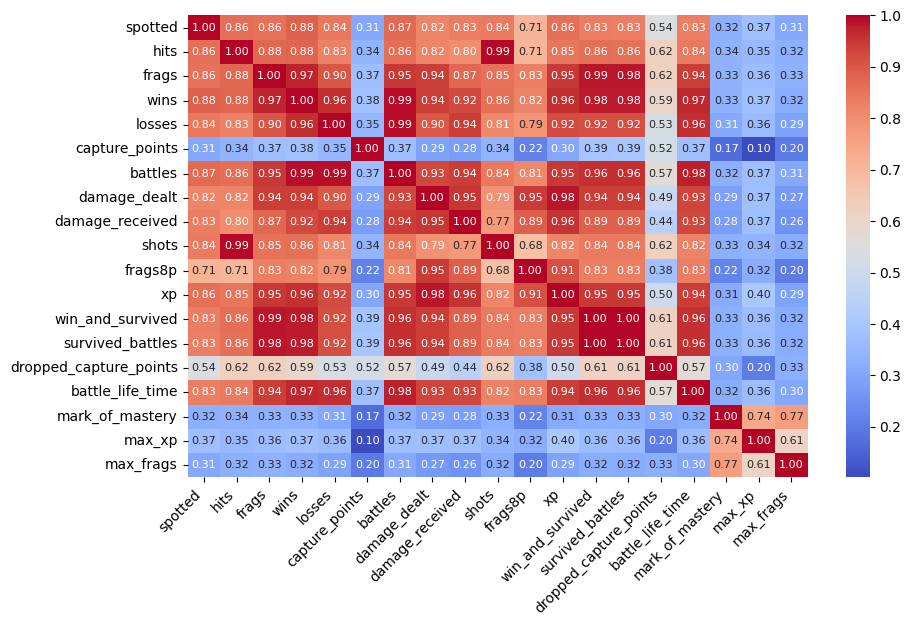

In [24]:
corrs = df.drop(["user_id", "tank_id"], axis=1).corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrs, annot=True, fmt=".2f", ax=ax, cmap="coolwarm", annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

Как можно заметить, много где высокие значения корреляций. К сожалению, это неизбежно из-за особенностей самих данных. Так, с ростом количества боев неизбежно будут изменяться и другие параметры, а изменение будет зависеть от действий игрока в бою. Точно также, связь win_and_survived и survived_battles, хоть они и имеют очень высокую корреляцию, но удаление одной из них невозможно, т.к. их комбинация позволяет делать выводы о ситуации, когда игрок победил, но не выжил в бою, либо выжил, но проиграл.

In [25]:
# т.к. многие колонки являются постоянно растущими значениями, то усредним их на количество боев
avg_cols = df.drop(
    ["user_id", "tank_id", "max_xp", "battles", "max_frags", "mark_of_mastery"], axis=1
).columns
df[avg_cols] = df[avg_cols].div(df["battles"], axis=0).astype("float32")

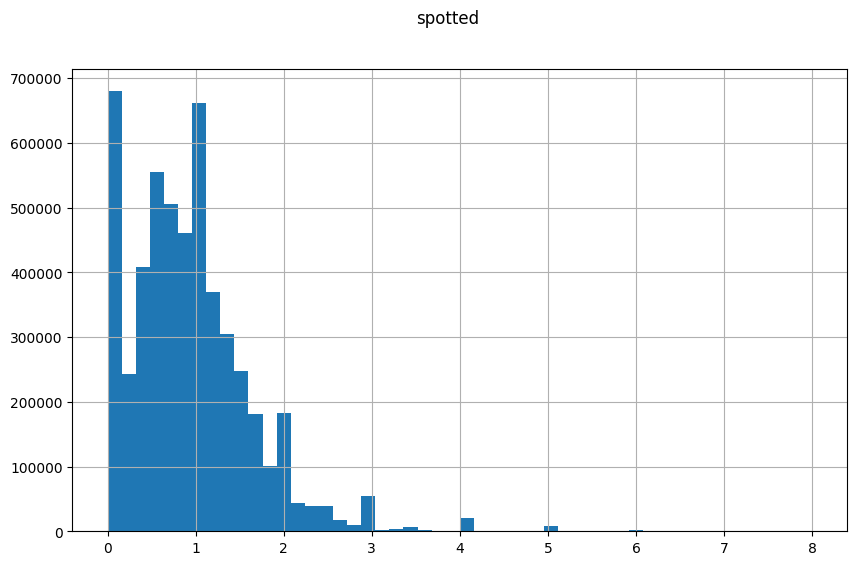

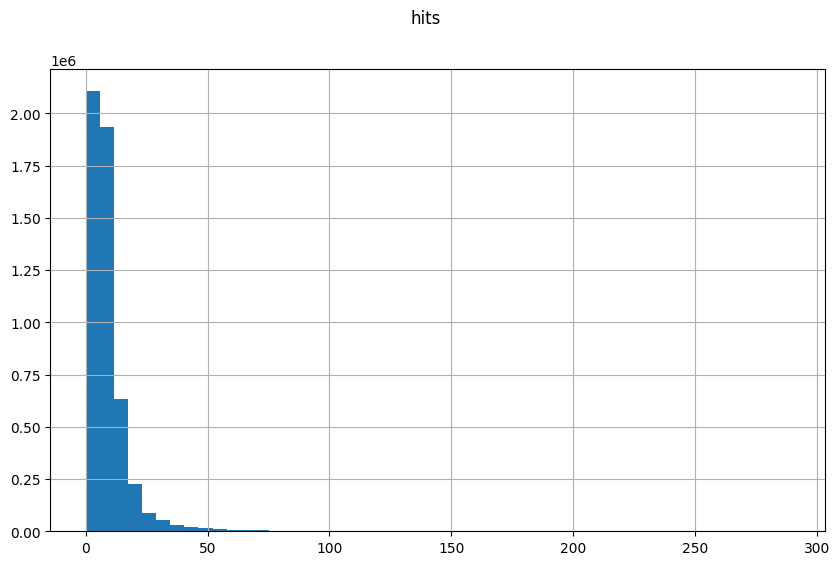

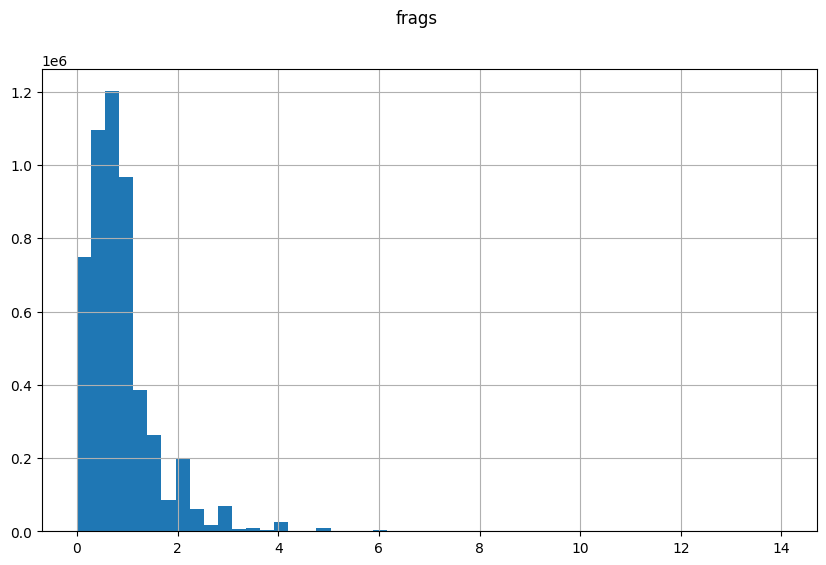

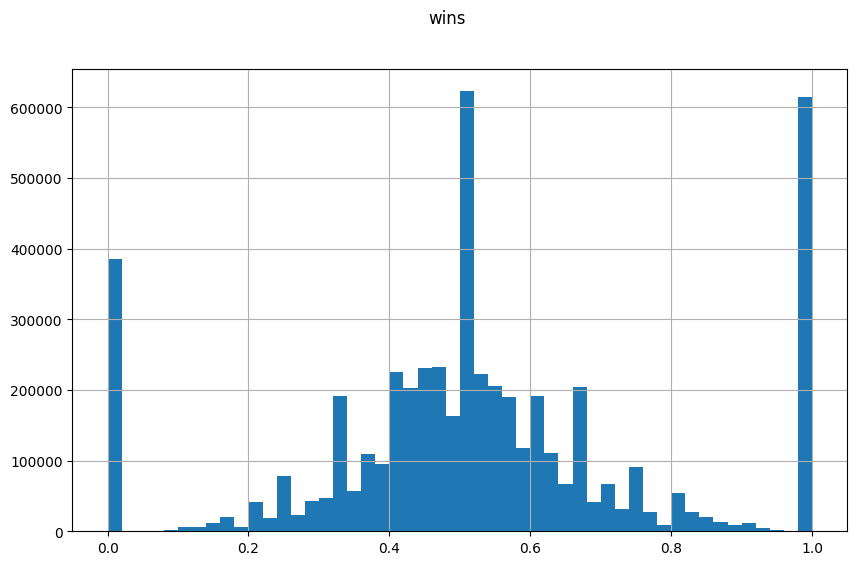

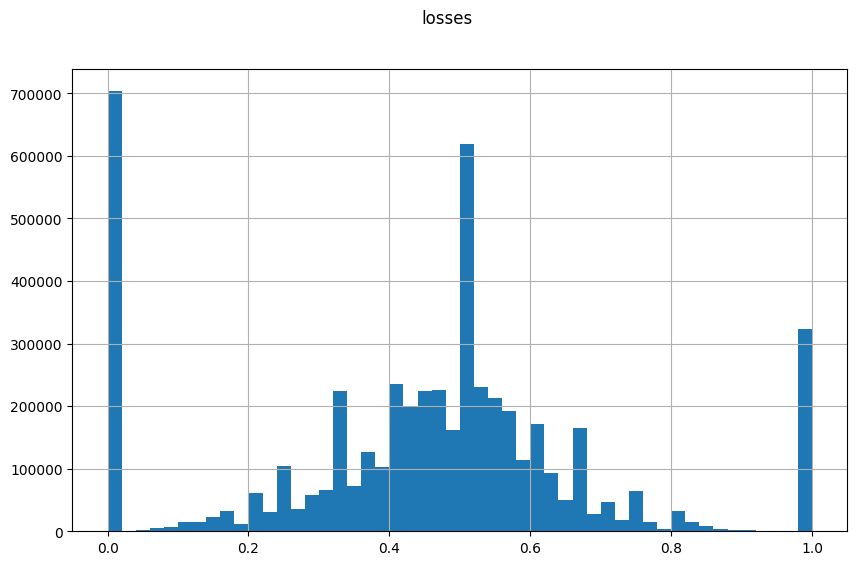

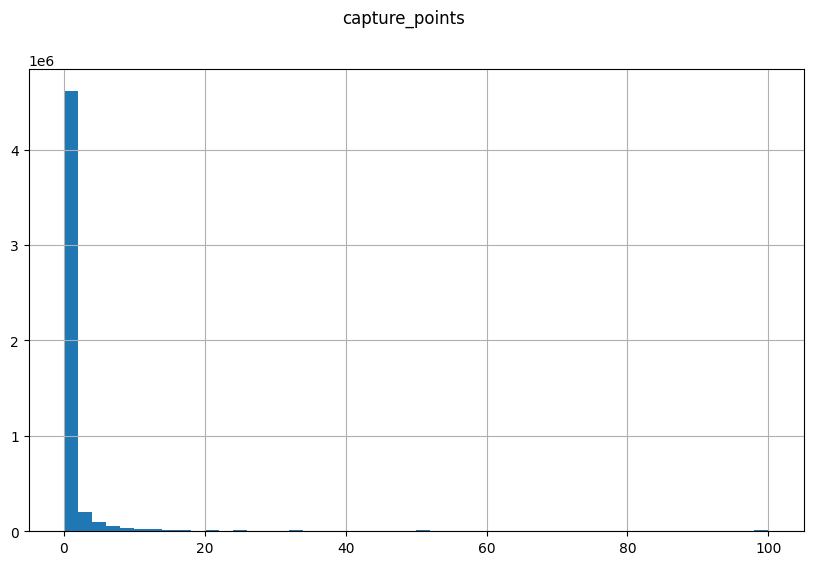

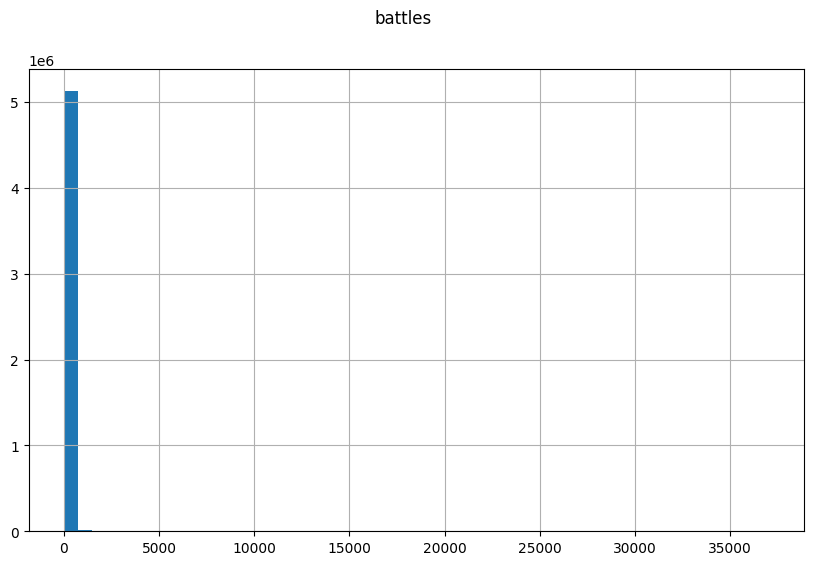

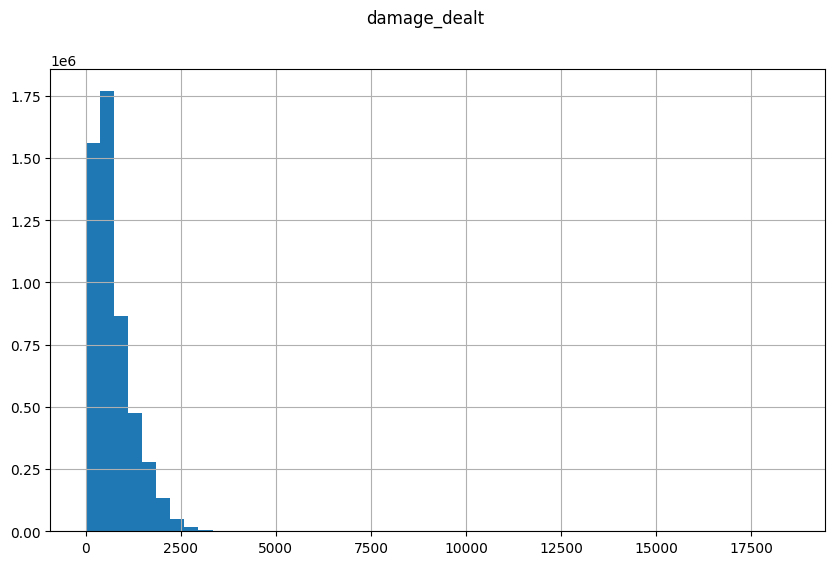

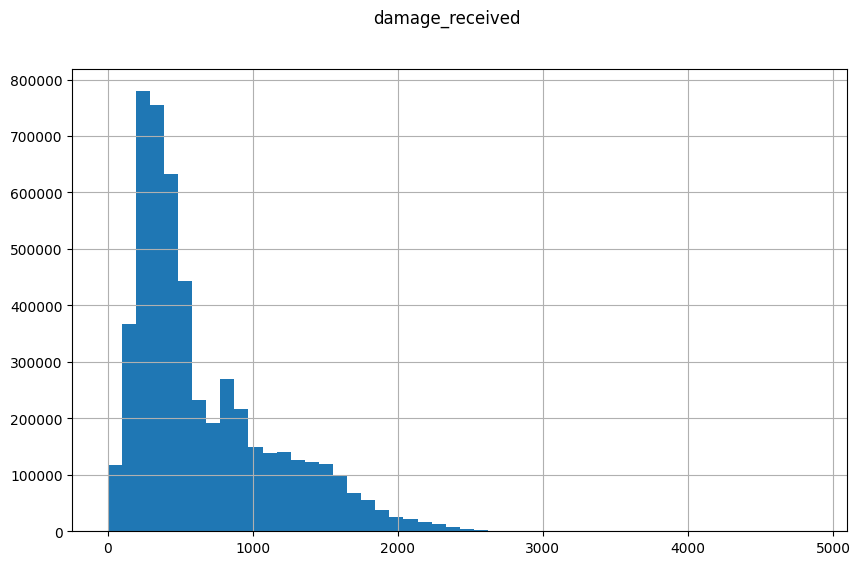

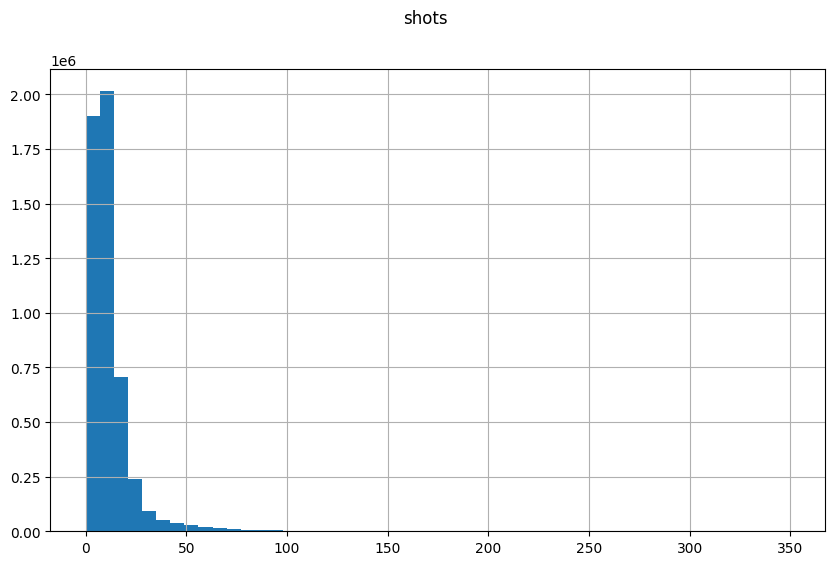

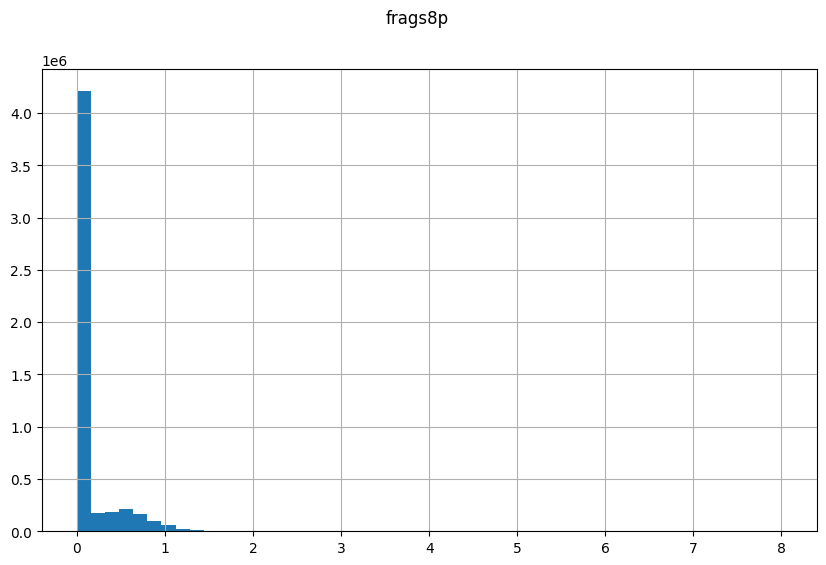

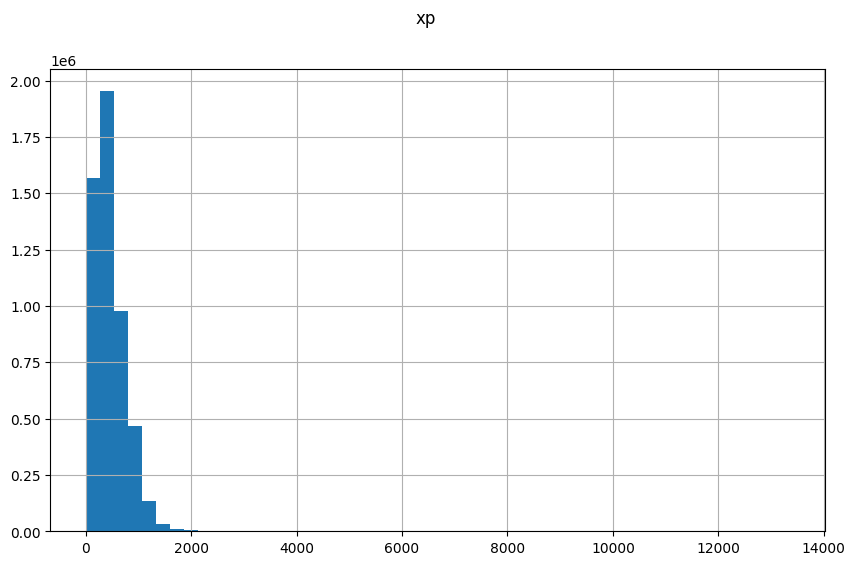

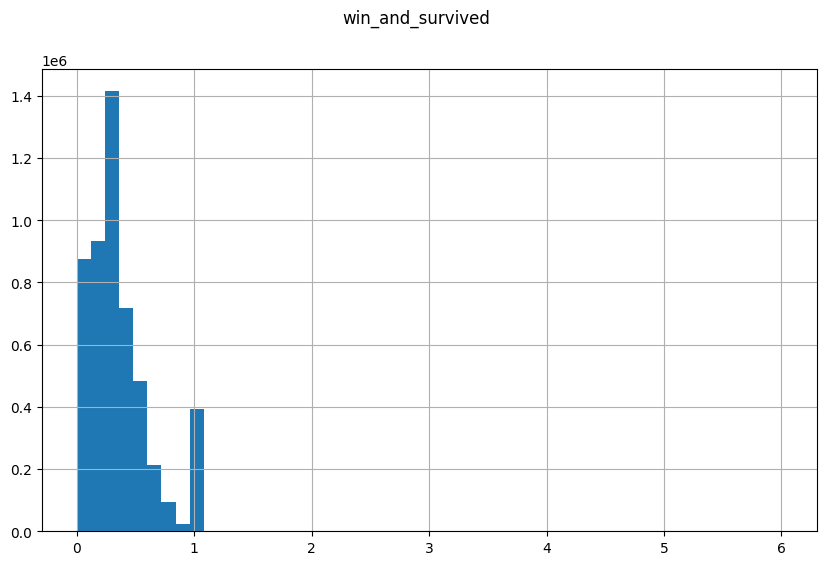

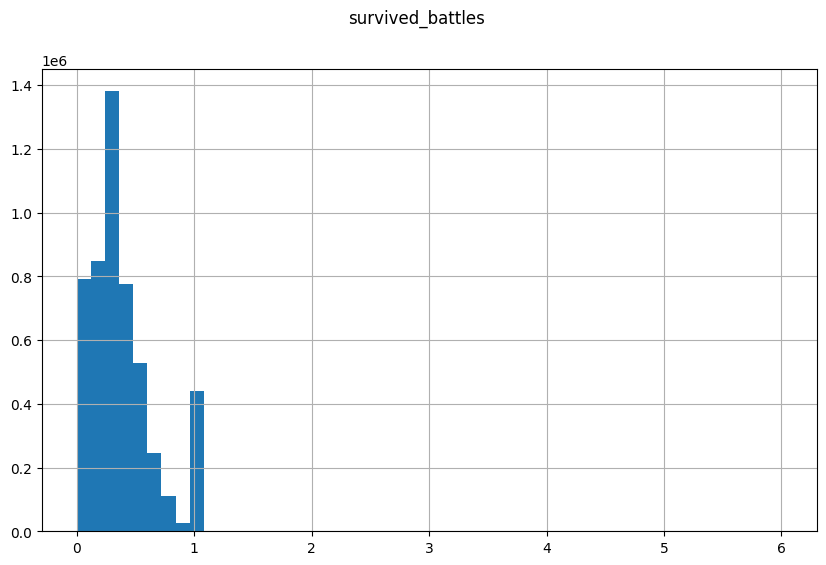

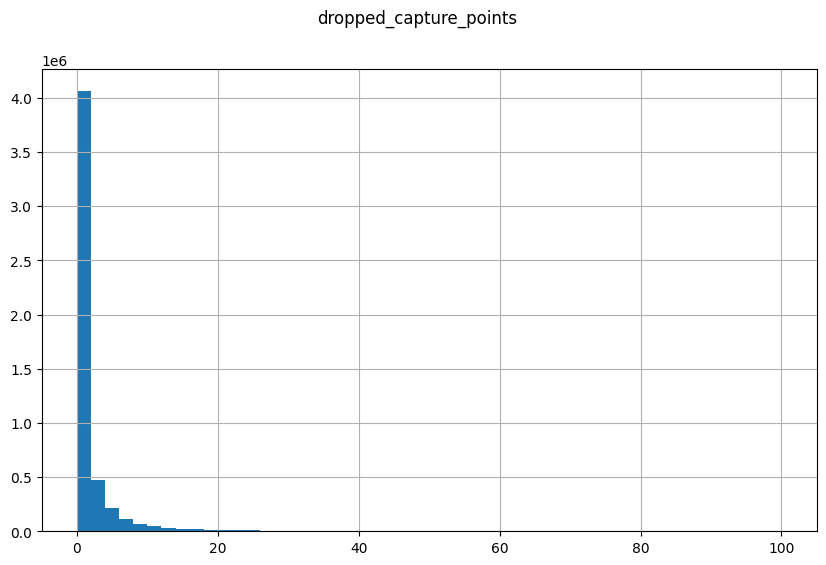

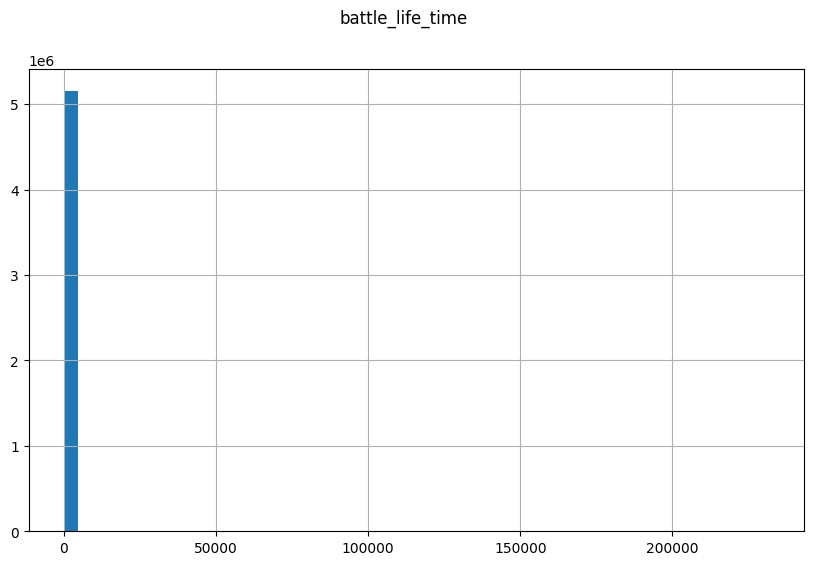

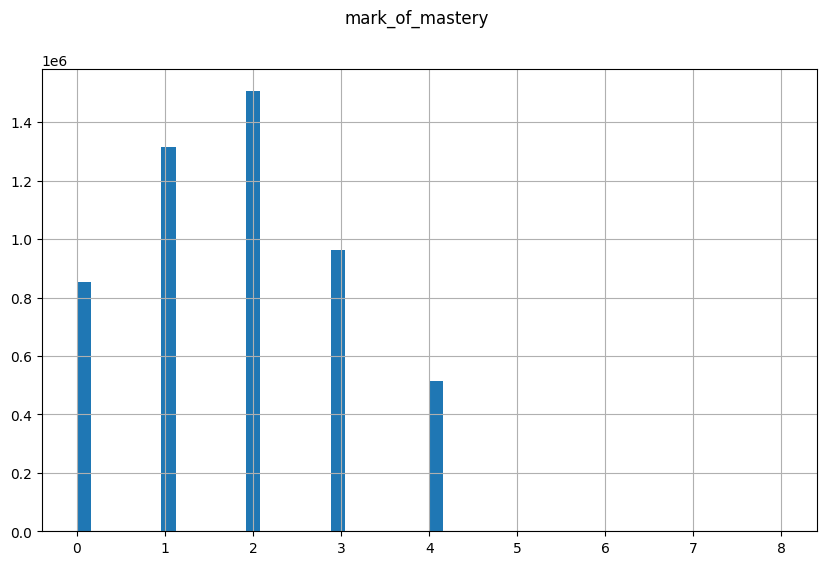

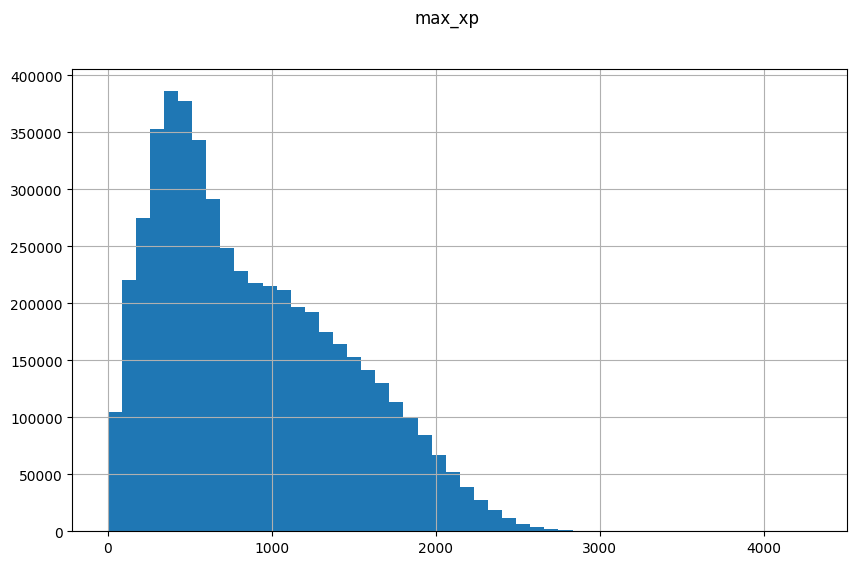

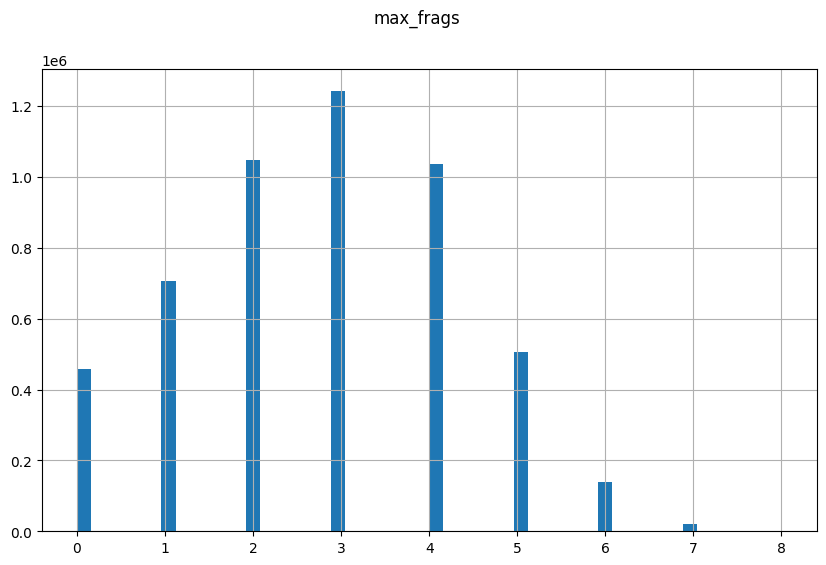

In [26]:
for col in df.drop(["user_id", "tank_id"], axis=1).columns:
    df[col].hist(bins=50, figsize=(10, 6))
    plt.suptitle(f"{col}")
    plt.show()

Исходя из графиков видно, что распределения близки к нормальному или логнормальному респределениям. Однако, на графиках с победами и поражениями есть большие хвосты в районах 0 и 1, предположительно это влияние того, что игрок сыграл малое количество боев (например, всего 1). Посмотрим на графики если отфильтровать данные на минимальное количество боев.

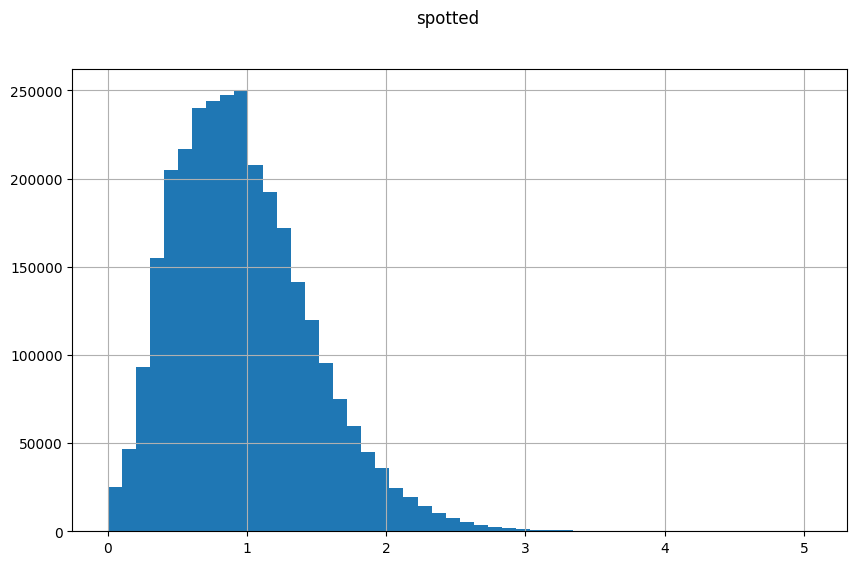

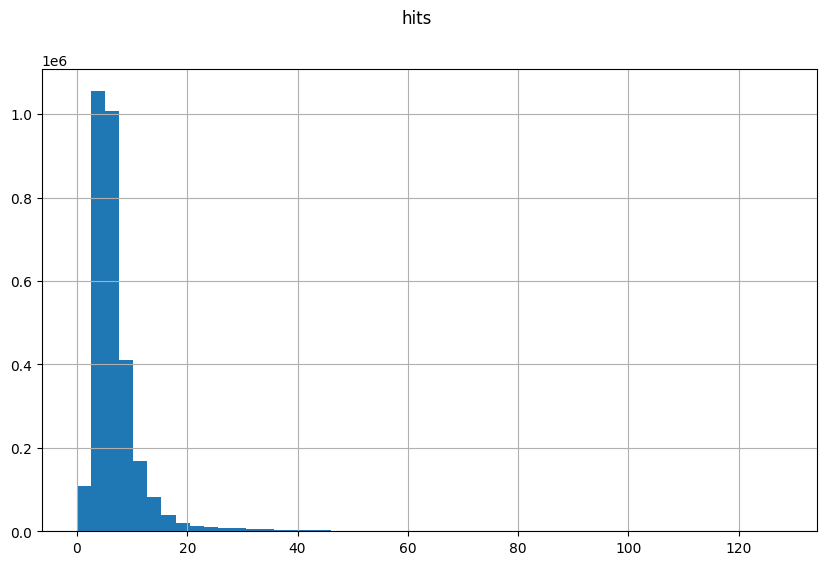

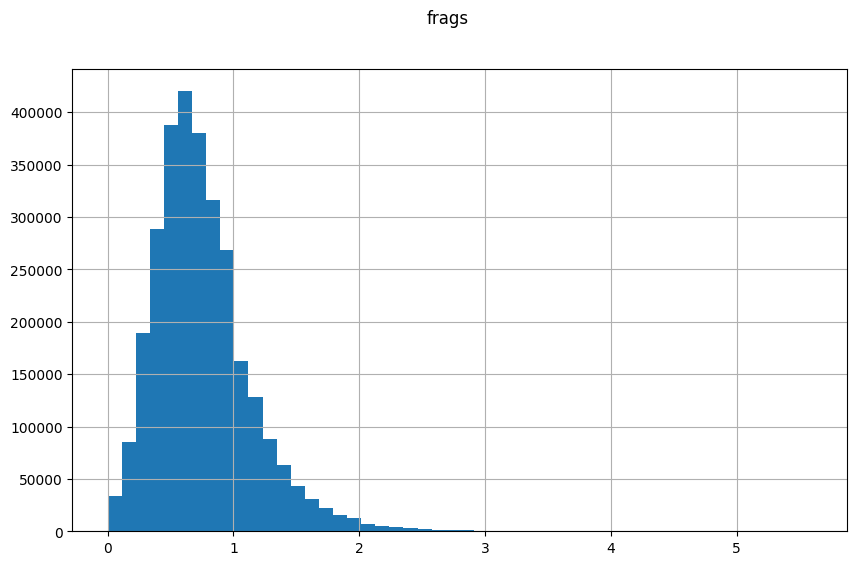

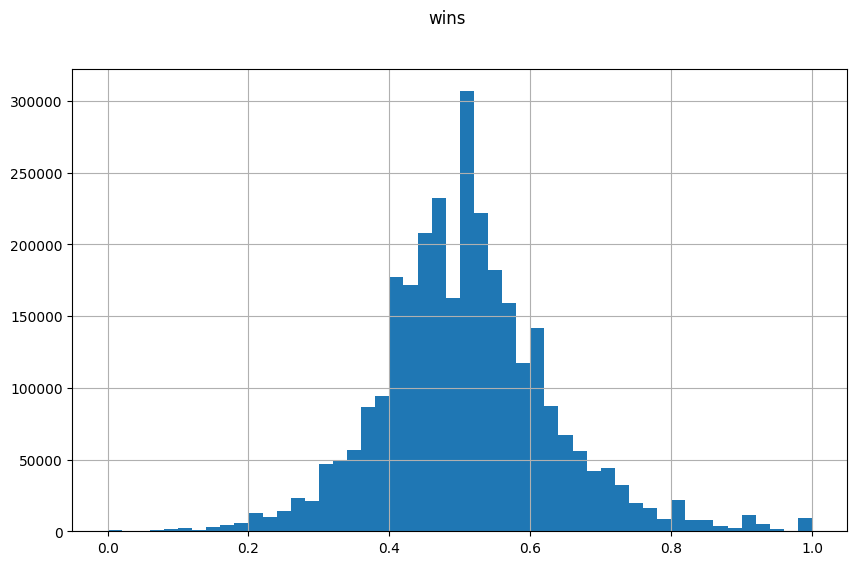

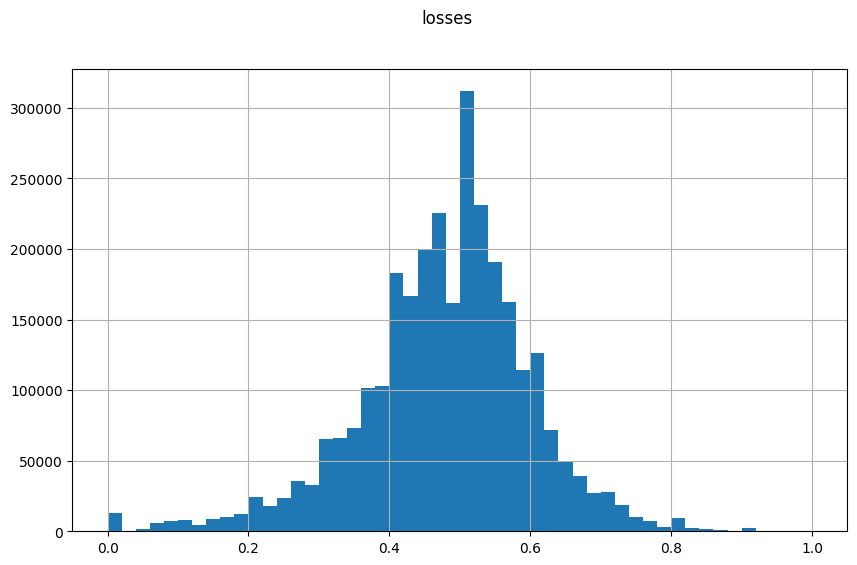

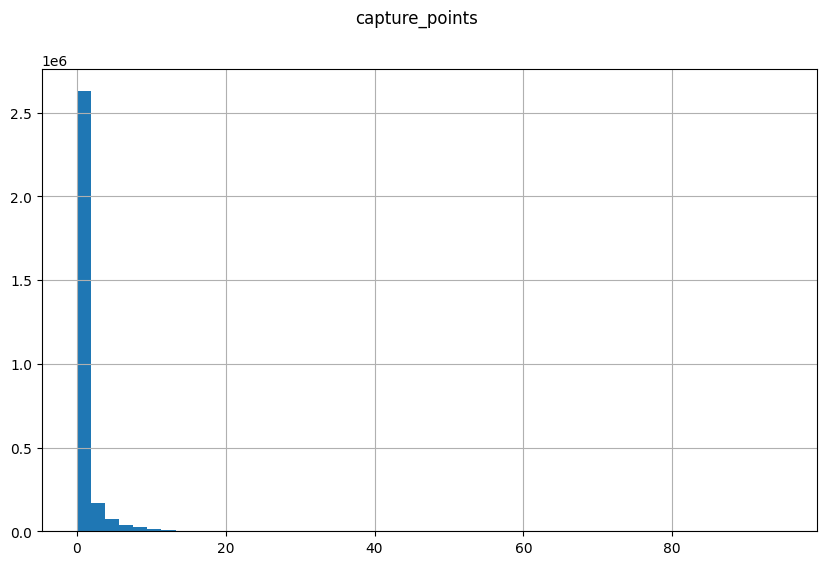

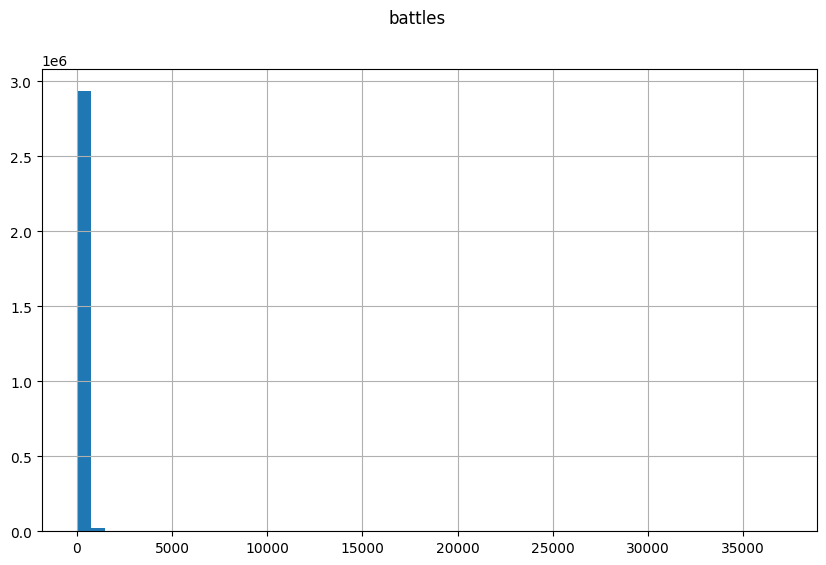

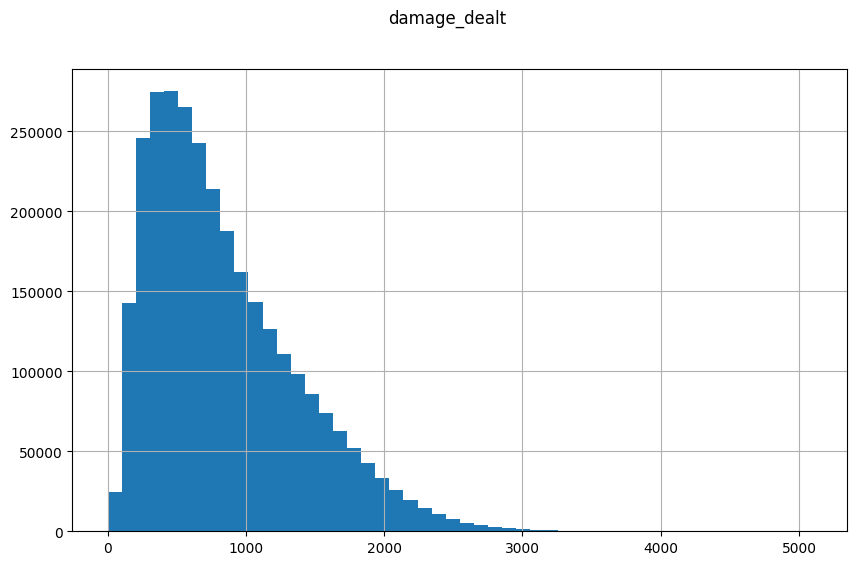

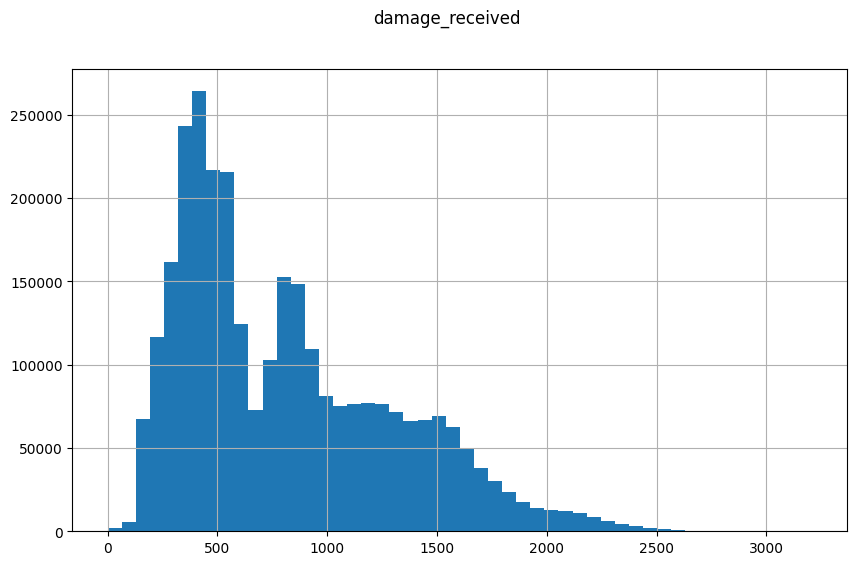

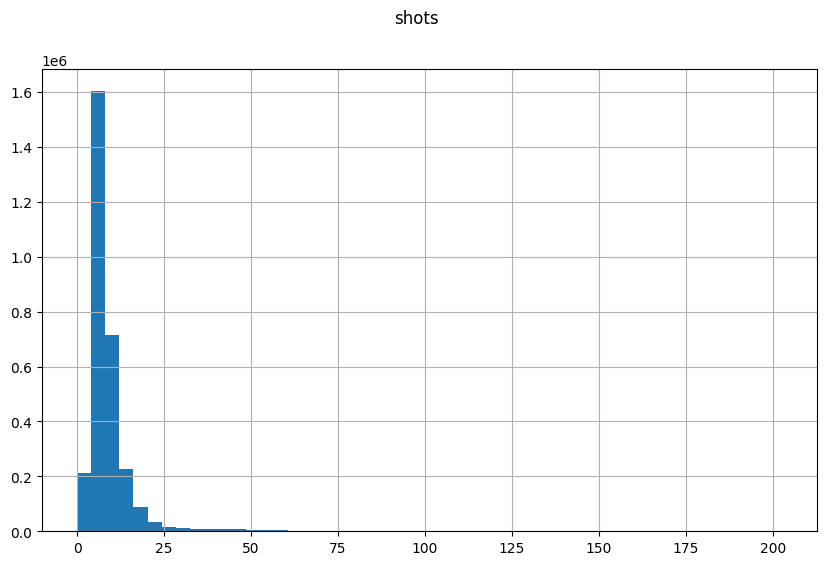

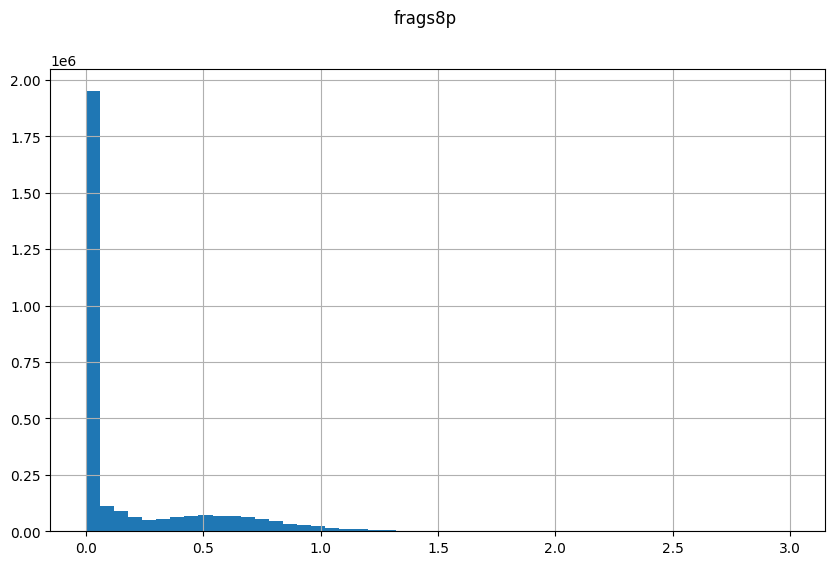

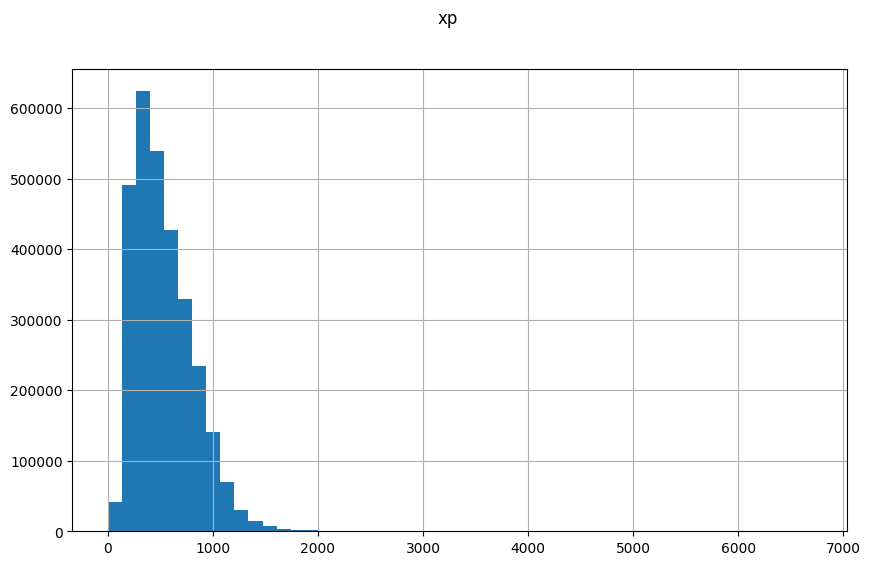

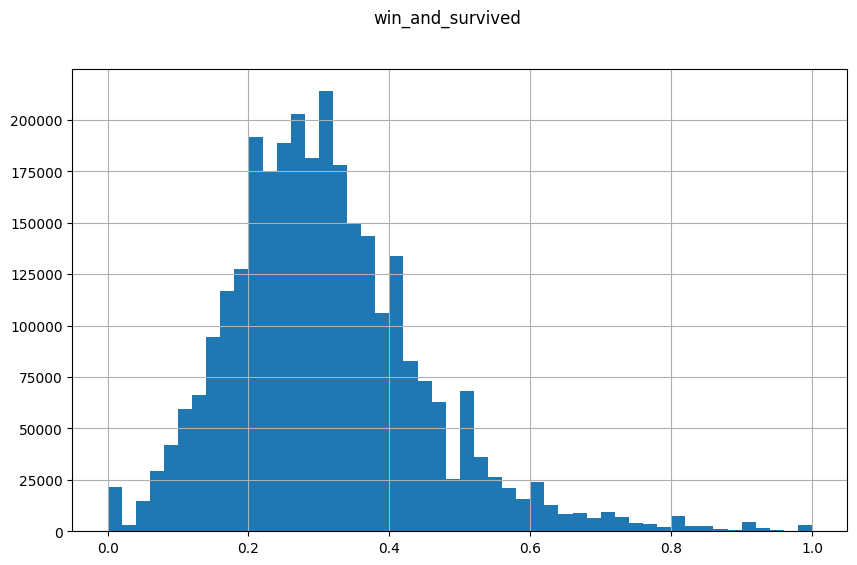

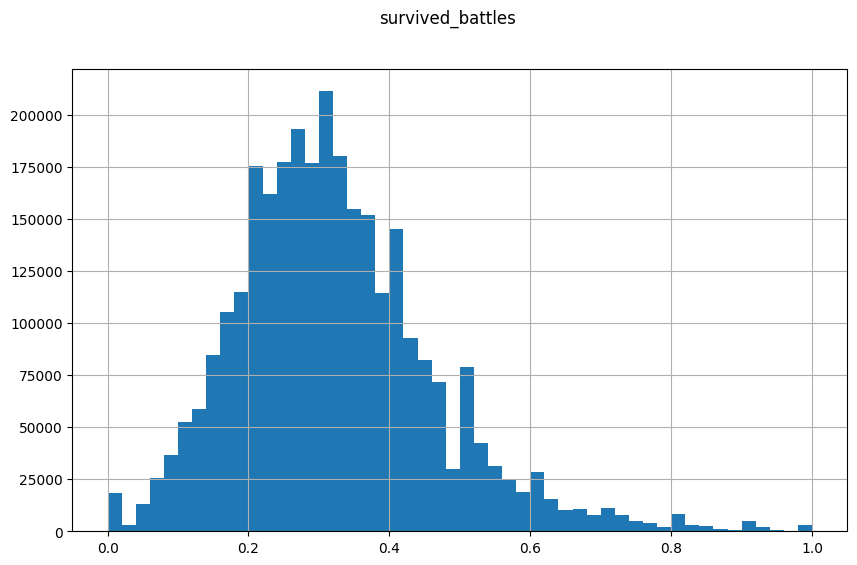

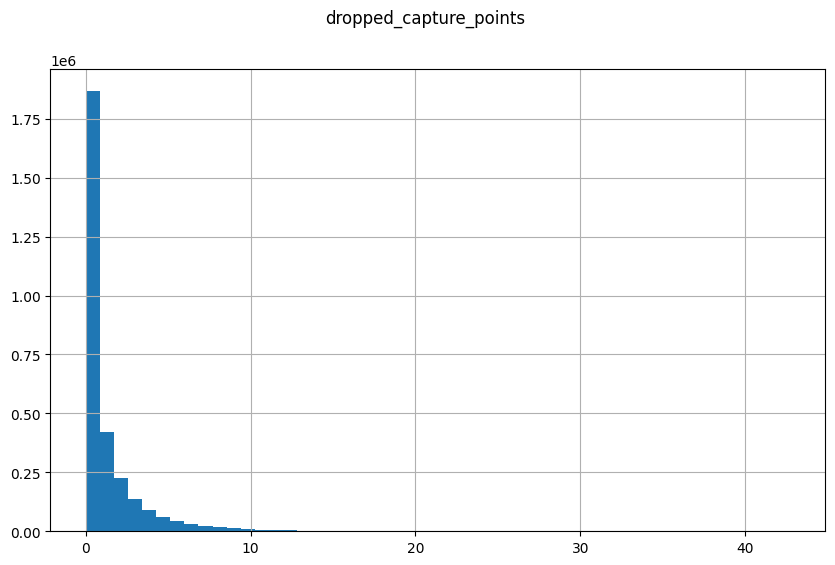

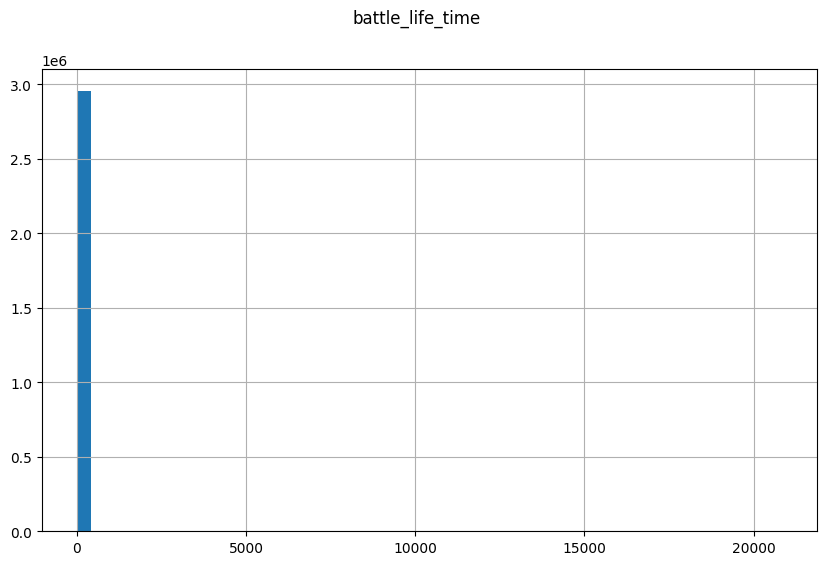

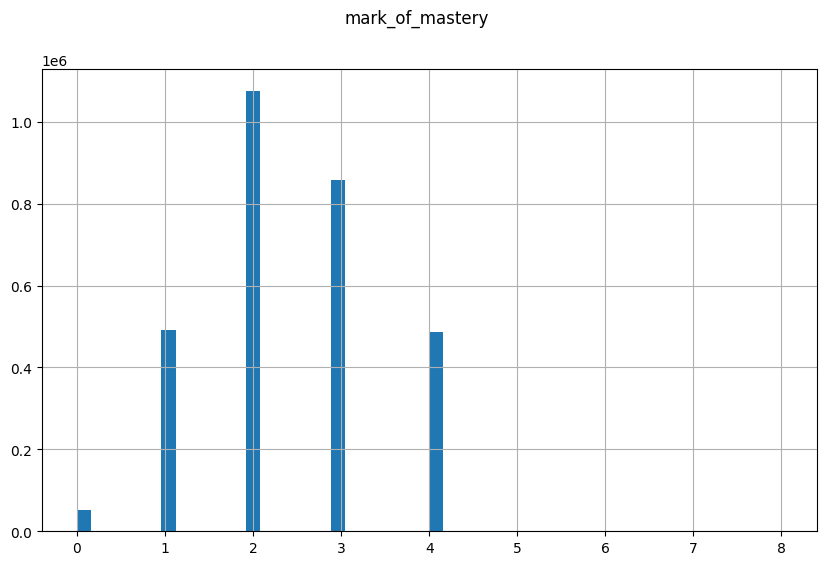

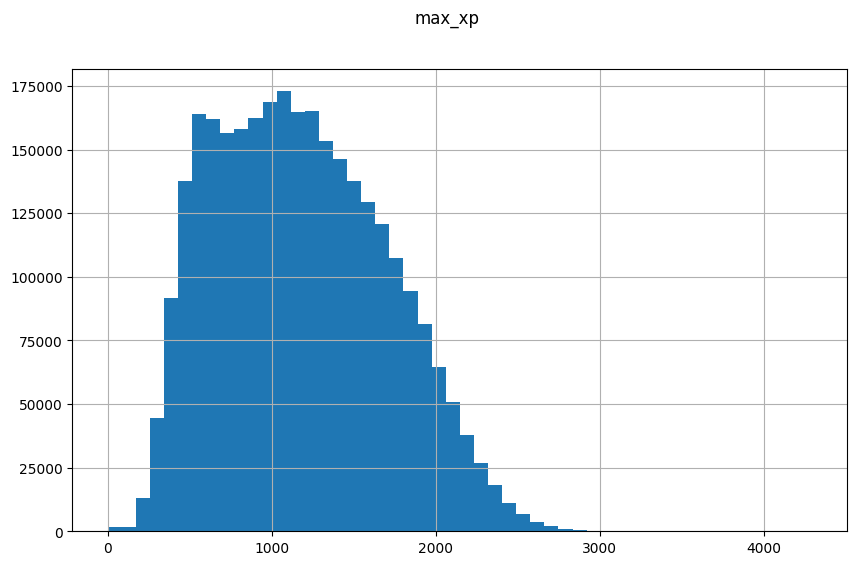

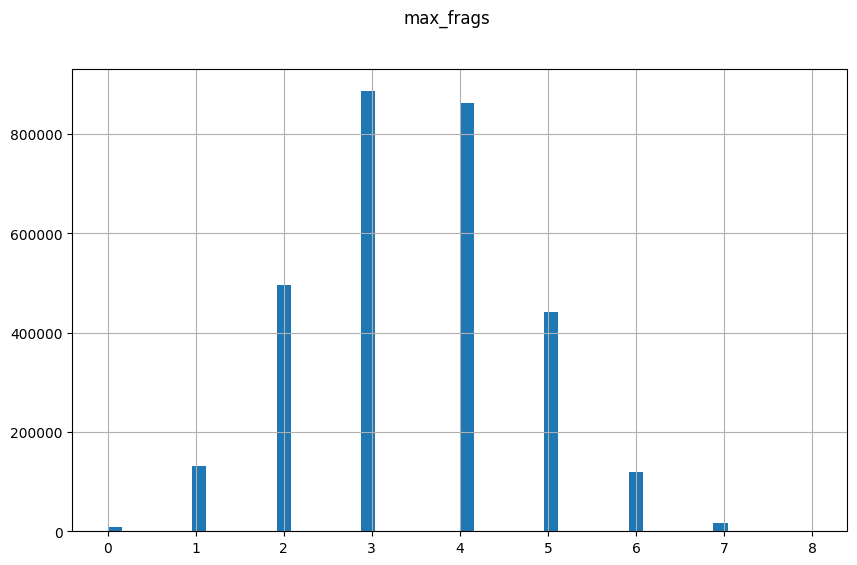

In [27]:
for col in df.drop(["user_id", "tank_id"], axis=1).columns:
    df.query("battles >= 10")[col].hist(bins=50, figsize=(10, 6))
    plt.suptitle(f"{col}")
    plt.show()

Как видим, отфильтровав танки с небольшим количеством боев, распределения данных еще больше приблизились к нормальным или логнормальным, а также мы избавились от шумовых данных. Это связано с тем, что чем меньше количество боев, тем больше влияние случайности (например, игроку могло не(повезти), игра могла закрыться сразу после загрузки в бой, а попасть обратно в тот же бой он не смог, из-за чего его полезность в бою была минимальна; или он мог сыграть только 2-3 боя в которых ему повезло с командой, но сам он ничего не успел сделать, например его убили с одного выстрела взорвав боеукладку или подпалив, а команда победила). Поэтмоу увеличивая минимальное количество боев мы получаем больше информации непосредственно о навыках владения танком игрока.
Таким образом, имеет смысл использовать данный фильтр и в дальнейшем.

In [28]:
# Отфильтруем данные прежде чем продолжать анализ
df = df.query("(battles >= 10) & (damage_dealt > 0)")

In [29]:
# Еще раз проверим по скольки премиум-танкам у нас остались данные после фильтрации
df[df.tank_id.isin(premium_df.tank_id.values)].tank_id.nunique()

279

Т.е. у нас есть данные по всем премиум-танкам без учетам 1 танка для фановых режимов и 3 танков с особым камуфляжем.

In [30]:
# Еще раз проверим по скольки обычным танкам у нас остались данные после фильтрации
df[df.tank_id.isin(general_df.tank_id.values)].tank_id.nunique()

240

Теперь добавим к данным информацию о танках

In [31]:
full_tanks_df = pd.concat([general_df, premium_df]).reset_index(drop=True)

In [32]:
df = df.join(full_tanks_df.set_index("tank_id"), on="tank_id")

In [33]:
general_df

,tank_id,nation,tier,type,name
0,1,ussr,5,mediumTank,Т-34
1,17,germany,5,mediumTank,Pz.Kpfw. IV Ausf. G
2,1569,usa,7,mediumTank,T20
3,8225,usa,8,AT-SPG,T28
4,1297,germany,7,mediumTank,Panther I
...,...,...,...,...,...
235,3681,japan,10,mediumTank,STB-1
236,7505,uk,3,mediumTank,Cruiser Mk. IV
237,6273,european,7,mediumTank,Konštrukta T-34/100
238,20049,uk,8,lightTank,FV301


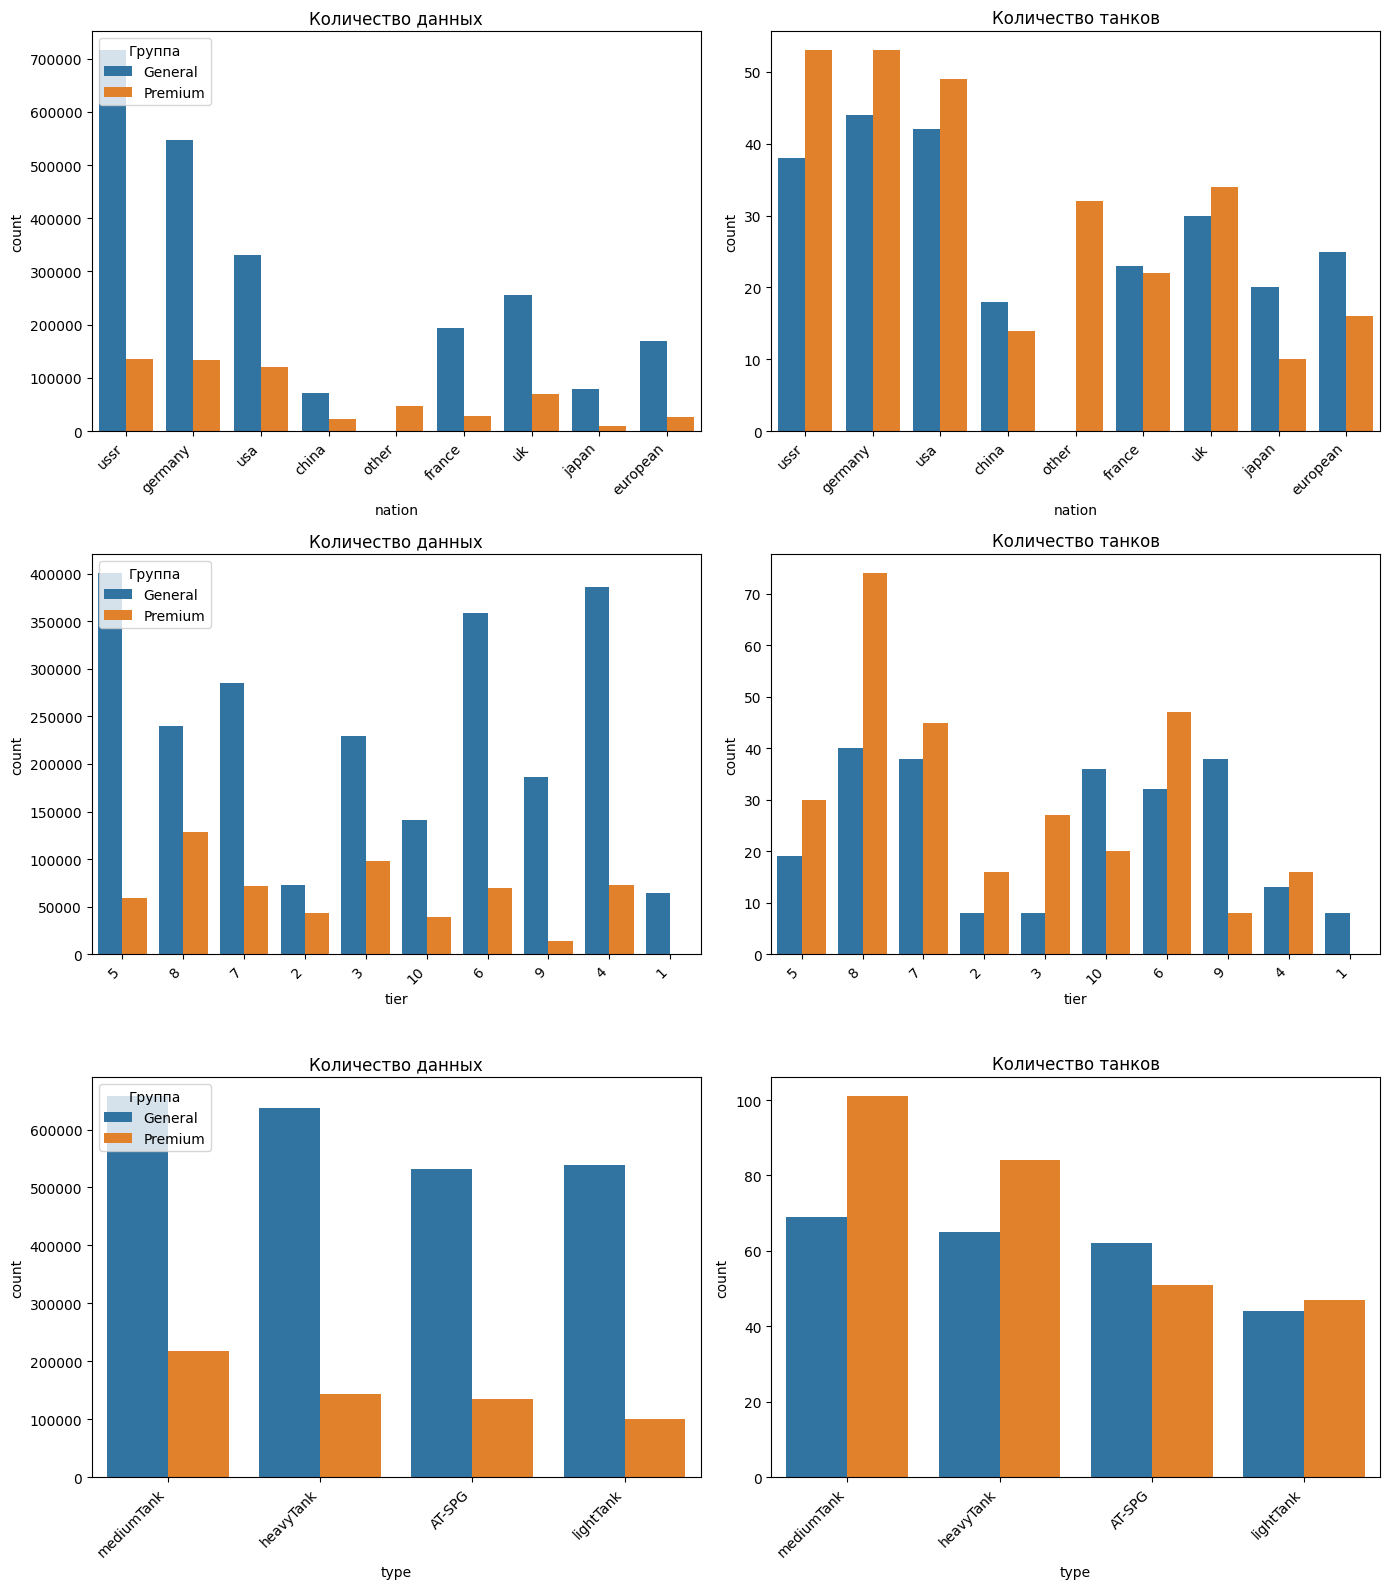

In [34]:
cols = ["nation", "tier", "type"]

labels1 = (
    df["tank_id"]
    .isin(premium_df.tank_id.values)
    .map({True: "Premium", False: "General"})
)
labels2 = (
    full_tanks_df["tank_id"]
    .isin(premium_df.tank_id.values)
    .map({True: "Premium", False: "General"})
)

fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(14, 16))

for i, col in enumerate(cols):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    order = list(
        dict.fromkeys(
            list(df[col].dropna().unique()) + list(full_tanks_df[col].dropna().unique())
        )
    )

    sns.countplot(data=df, x=col, hue=labels1, order=order, ax=ax1)
    ax1.set_title("Количество данных")
    sns.countplot(data=full_tanks_df, x=col, hue=labels2, order=order, ax=ax2)
    ax2.set_title("Количество танков")

    for a in (ax1, ax2):
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")

    handles, legend_labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, legend_labels, title="Группа", loc="upper left")
    if ax2.get_legend() is not None:
        ax2.get_legend().remove()

plt.tight_layout()
plt.show()

Исходя из сравнения графиков можно заметить, что зачастую распределение количества танков совпадает с распределением записей об игре на них. Так, для премиум танков распределения очень похожи, в то время, как для обычных танков есть редкие исключения (например, хоть танков СССР и меньше, чем танков Германии или США, но записей по ним значитально больше, чем по танкам Германии и США, что скорее всего связано с тем, что мы рассматриваем данные СНГ региона; хоть танков 5 уровня существенно меньше, но данных по ним больше всего, что вероятнее всего связано с тем, что обычно с 5 уровня можно прокачать несколько танков к разным веткам танков 10-го уровня).

## Подготовка данных

Поскольку мы хотим использовать данные об игре на обычных танках в качестве фичей, а предсказывать средний урон на премиум-танках, то подготовим датасет.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2959067 entries, 0 to 5151309
Data columns (total 62 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   tank_id                                    int32  
 1   user_id                                    int32  
 2   spotted                                    float32
 3   hits                                       float32
 4   frags                                      float32
 5   wins                                       float32
 6   losses                                     float32
 7   capture_points                             float32
 8   battles                                    int32  
 9   damage_dealt                               float32
 10  damage_received                            float32
 11  shots                                      float32
 12  frags8p                                    float32
 13  xp                                         floa

In [36]:
df = df.drop(["name", "default_profile.signal_range"], axis=1)
default_cols = [col for col in df.columns if "default_profile" in col]
df[default_cols] = df[default_cols].astype("float32")

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2959067 entries, 0 to 5151309
Data columns (total 60 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   tank_id                                    int32  
 1   user_id                                    int32  
 2   spotted                                    float32
 3   hits                                       float32
 4   frags                                      float32
 5   wins                                       float32
 6   losses                                     float32
 7   capture_points                             float32
 8   battles                                    int32  
 9   damage_dealt                               float32
 10  damage_received                            float32
 11  shots                                      float32
 12  frags8p                                    float32
 13  xp                                         floa

In [38]:
general_data_df = df[df.tank_id.isin(general_df.tank_id)]
prem_data_df = df[df.tank_id.isin(premium_df.tank_id)]

In [39]:
del df

In [40]:
# убираем колонки с характеристиками обычных танков, т.к. они изменяются в зависимости от прокачки и мы не можем знать, на какой конфигурации играл игрок и сколько боев, поэтому используем аггрегированные данные
general_data_df = general_data_df.dropna(axis=1)
general_data_df

,tank_id,user_id,spotted,hits,frags,wins,losses,capture_points,battles,damage_dealt,...,win_and_survived,survived_battles,dropped_capture_points,battle_life_time,mark_of_mastery,max_xp,max_frags,nation,tier,type
0,1,77,1.291667,10.902778,0.930556,0.500000,0.458333,1.680556,72,801.291687,...,0.277778,0.277778,1.250000,140.291672,3,1342,5,ussr,5,mediumTank
1,1,225,1.725000,8.775000,0.800000,0.475000,0.500000,0.025000,40,628.599976,...,0.200000,0.200000,0.350000,132.649994,3,1348,5,ussr,5,mediumTank
2,1,324,0.825000,5.550000,0.600000,0.600000,0.400000,0.000000,40,677.325012,...,0.375000,0.375000,0.925000,144.274994,3,1128,3,ussr,5,mediumTank
4,1,354,0.967742,5.903226,0.838710,0.645161,0.354839,0.000000,31,612.483887,...,0.354839,0.354839,0.387097,162.000000,3,1195,5,ussr,5,mediumTank
5,1,385,1.305085,7.898305,0.813559,0.694915,0.271186,5.084746,59,532.610168,...,0.372881,0.372881,1.305085,160.372879,3,888,2,ussr,5,mediumTank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5075018,58641,250050903,0.850000,4.650000,0.600000,0.650000,0.350000,0.150000,20,2001.599976,...,0.300000,0.300000,0.200000,172.000000,2,1879,2,germany,10,heavyTank
5075020,58641,250050943,0.905063,4.734177,0.772152,0.491561,0.504219,0.533755,474,1954.316406,...,0.348101,0.358650,0.732068,190.103378,4,2377,4,germany,10,heavyTank
5075021,58641,250051095,0.739130,4.347826,0.717391,0.521739,0.478261,0.000000,46,1743.478271,...,0.391304,0.391304,1.804348,235.978256,2,2086,4,germany,10,heavyTank
5075025,58641,250318134,1.000000,5.722222,0.944444,0.388889,0.611111,0.000000,18,2105.111084,...,0.388889,0.388889,0.833333,187.833328,2,1774,3,germany,10,heavyTank


In [41]:
# удаляем категориальные колонки для обычных танков, т.к. они будут константными в зависимости от танка и не будут нести информации
general_data_df = general_data_df.drop(["nation", "tier", "type"], axis=1)

In [42]:
# преобразуем статистику игры на обычных танках в long формат для того, чтобы у нас была одна строка на пользователя
general_data_df = general_data_df.pivot(index="user_id", columns="tank_id")
general_data_df.columns = [
    "_".join([str(part) for part in col if part not in (None, "")])
    for col in general_data_df.columns
]
general_data_df.reset_index(inplace=True)

In [43]:
# для премиум танков наоборот оставляем колонки с характеристиками, категориальные и целевую переменную по нанесенному урону
# а также оставляем только танки уровня 5 и выше исходя из анализа ошибок предсказаний модели на предыдущей итерации
# сам анализ в последнем разделе ноутбука
prem_cols = (
    ["user_id", "tank_id"]
    + [col for col in prem_data_df.columns if "default_profile" in col]
    + ["nation", "tier", "type", "damage_dealt"]
)
prem_data_df = prem_data_df[prem_cols].query("tier >= 5")

In [45]:
# формируем финальный датасет из двух датафрэймов
final_df = general_data_df.merge(prem_data_df, on="user_id", how="inner")

In [46]:
final_df.shape

(380249, 4602)

In [47]:
del general_data_df

In [48]:
gc.collect()

0

Разделим пользователей так, чтобы один пользователь не мог быть в нескольких подвыборках и при этом, чтобы каждый танак был в каждой подвыборке

In [49]:
users = final_df["user_id"].unique()
tanks = final_df["tank_id"].unique()

user_index = {u: i for i, u in enumerate(users)}
tank_index = {t: i for i, t in enumerate(tanks)}

n_users = len(users)
n_tanks = len(tanks)

In [50]:
X = np.arange(n_users).reshape(-1, 1)
Y = np.zeros((n_users, n_tanks), dtype=int)

In [51]:
for row in tqdm(final_df.itertuples(index=False)):
    uid = row.user_id
    tid = row.tank_id
    Y[user_index[uid], tank_index[tid]] = 1

380249it [03:12, 1977.61it/s]


In [52]:
X_train, Y_train, X_temp, Y_temp = iterative_train_test_split(X, Y, test_size=0.4)

In [53]:
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_temp, Y_temp, test_size=0.5)

In [54]:
train_idxs = X_train.flatten().astype(int)
val_idxs = X_val.flatten().astype(int)
test_idxs = X_test.flatten().astype(int)

In [55]:
train_users = users[train_idxs]
val_users = users[val_idxs]
test_users = users[test_idxs]

Посмотрим, как разделились данные.

In [56]:
final_df[final_df.user_id.isin(train_users)].groupby(
    "tank_id"
).user_id.nunique().sort_values()

tank_id
18497       7
4705        9
22305      11
4449       20
7025       41
         ... 
54289    3489
64337    3712
9297     3739
5489     3768
54785    6313
Name: user_id, Length: 220, dtype: int64

In [57]:
final_df[final_df.user_id.isin(val_users)].groupby(
    "tank_id"
).user_id.nunique().sort_values()

tank_id
18497       2
4705        5
4465        9
22305       9
4449       10
         ... 
54289    1131
64337    1237
5489     1256
9297     1356
54785    2105
Name: user_id, Length: 220, dtype: int64

In [58]:
final_df[final_df.user_id.isin(test_users)].groupby(
    "tank_id"
).user_id.nunique().sort_values()

tank_id
18497       2
22305       4
4705        8
4449       10
7025       14
         ... 
54289    1195
64337    1237
5489     1256
9297     1373
54785    2104
Name: user_id, Length: 220, dtype: int64

In [59]:
final_df.groupby("tank_id").user_id.nunique().sort_values()

tank_id
18497       11
4705        22
22305       24
4449        40
4465        71
         ...  
54289     5815
64337     6186
5489      6280
9297      6468
54785    10522
Name: user_id, Length: 220, dtype: int64

In [60]:
del X
del Y
del X_temp
del Y_temp
gc.collect()

0

In [61]:
print(f"Размерность train: {final_df[final_df.user_id.isin(train_users)].shape}")
print(f"Размерность val: {final_df[final_df.user_id.isin(val_users)].shape}")
print(f"Размерность test: {final_df[final_df.user_id.isin(test_users)].shape}")

Размерность train: (224268, 4602)
Размерность val: (76477, 4602)
Размерность test: (79504, 4602)


Ввиду ограничений RAM и для уменьшения дисбаланса количества записей по каждому танку отсэмплируем данные таким образом, чтобы по каждому танку было не более 500 записей.

In [62]:
def downsample_pairs(train_df, cap_per_tank=500, random_state=42):
    rng = np.random.RandomState(random_state)

    # Уникальные пары (user_id, tank_id) — если в train есть дубликаты, оставляем их как отдельные строки,
    # но выборка делается по уникальным парам, чтобы не дробить одного игрока на одном танке.
    pairs = train_df[["user_id", "tank_id"]].drop_duplicates().reset_index(drop=True)

    pairs["strata"] = "all"  # единый страта

    # подготовим выборку: для каждого tank_id
    selected_pairs = []
    # группируем по tank_id и внутри — по strata (если есть)
    grouped = pairs.groupby("tank_id")
    for tank, grp in grouped:
        m = len(grp)
        if m <= cap_per_tank:
            # берем все пары
            selected_pairs.append(grp[["user_id", "tank_id"]])
            continue

        # если нужно стратифицировать внутри танка — распределяем cap пропорционально по strata
        strata_counts = grp["strata"].value_counts().to_dict()
        # начальная аллокация: пропорционально размерам страт
        alloc = {}
        total = sum(strata_counts.values())
        remaining = cap_per_tank
        # floor allocation
        for s, cnt in strata_counts.items():
            a = int(np.floor(cnt / total * cap_per_tank))
            alloc[s] = a
            remaining -= a
        # распределяем остаток по стратам с наибольшей дробной частью
        if remaining > 0:
            frac = {
                s: (strata_counts[s] / total * cap_per_tank) - alloc[s]
                for s in strata_counts
            }
            for s in sorted(frac, key=lambda x: -frac[x])[:remaining]:
                alloc[s] += 1

        # теперь для каждой strata делаем случайную выборку alloc[s] пар
        picks = []
        for s, a in alloc.items():
            if a <= 0:
                continue
            sub = grp[grp["strata"] == s]
            # если a >= len(sub) — берем все
            if a >= len(sub):
                picks.append(sub[["user_id", "tank_id"]])
            else:
                # reproducible random sample
                idx = rng.choice(sub.index.values, size=a, replace=False)
                picks.append(sub.loc[idx, ["user_id", "tank_id"]])
        selected_pairs.append(pd.concat(picks, ignore_index=True))

    selected_pairs_df = pd.concat(selected_pairs, ignore_index=True)

    # Теперь фильтруем исходный train_df по выбранным парам (user_id, tank_id)
    # Для быстрого фильтра используем merge
    result = train_df.merge(
        selected_pairs_df.drop_duplicates(), on=["user_id", "tank_id"], how="inner"
    )

    # опционально: вернуть также статистику
    stats = {
        "original_pairs": len(pairs),
        "selected_pairs": len(selected_pairs_df),
        "original_rows": len(train_df),
        "selected_rows": len(result),
        "per_tank_before": pairs.groupby("tank_id").size().describe().to_dict(),
        "per_tank_after": selected_pairs_df.groupby("tank_id")
        .size()
        .describe()
        .to_dict(),
    }
    return result, stats

In [63]:
train, stats = downsample_pairs(final_df[final_df.user_id.isin(train_users)])
val, stats = downsample_pairs(final_df[final_df.user_id.isin(val_users)])
test, stats = downsample_pairs(final_df[final_df.user_id.isin(test_users)])

In [64]:
# Посчитаем средний урон для каждого прем-танка для бэйзлайна модели
avg_damage_dealt = train.groupby("tank_id").damage_dealt.mean().to_dict()

In [65]:
joblib.dump(avg_damage_dealt, "avg_damage_dealt.joblib")

['avg_damage_dealt.joblib']

In [66]:
X_train = train.drop("damage_dealt", axis=1)
y_train = train["damage_dealt"]

In [67]:
X_val = val.drop("damage_dealt", axis=1)
y_val = val["damage_dealt"]

In [68]:
X_test = test.drop("damage_dealt", axis=1)
y_test = test["damage_dealt"]

In [69]:
train_tank_ids = X_train.tank_id
val_tank_ids = X_val.tank_id
test_tank_ids = X_test.tank_id

In [70]:
X_train.drop(["user_id", "tank_id"], axis=1, inplace=True)
X_val.drop(["user_id", "tank_id"], axis=1, inplace=True)
X_test.drop(["user_id", "tank_id"], axis=1, inplace=True)

In [71]:
del final_df
del train
del val
del test
gc.collect()

0

In [72]:
cat_cols = [col for col in X_train.columns if "mark_of_mastery" in col] + [
    "nation",
    "tier",
    "type",
]
num_cols = [col for col in X_train.columns if col not in cat_cols]

In [73]:
X_train[cat_cols] = X_train[cat_cols].astype("category")
X_val[cat_cols] = X_val[cat_cols].astype("category")
X_test[cat_cols] = X_test[cat_cols].astype("category")

In [74]:
means = np.nanmean(X_train[num_cols], axis=0)
stds = np.nanstd(X_train[num_cols], axis=0)
stds[stds == 0] = 1.0

In [75]:
joblib.dump(means, "means.joblib")
joblib.dump(stds, "stds.joblib")

['stds.joblib']

In [76]:
def scale_data(data, means, stds):
    n = data.shape[0]
    X_values = data.to_numpy(dtype=np.float32)
    step = 10000
    for i in tqdm(range(0, n, step)):
        X_values[i : i + step] = (X_values[i : i + step] - means) / stds

    return X_values

In [77]:
X_train[num_cols] = scale_data(X_train[num_cols], means, stds)
X_val[num_cols] = scale_data(X_val[num_cols], means, stds)
X_test[num_cols] = scale_data(X_test[num_cols], means, stds)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.49it/s]


## Моделирование

Посмотрим на первый baseline, когда мы предсказываем для премиум-танков просто средний урон по этим танкам.

In [78]:
# Метрики на обучающей выборке
preds = train_tank_ids.map(avg_damage_dealt)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.580
RMSE: 329.512
MAE: 250.697
MAPE: 0.241


In [79]:
# Метрики на валидационной выборке
preds = val_tank_ids.map(avg_damage_dealt)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.598
RMSE: 326.609
MAE: 247.804
MAPE: 0.235


In [80]:
# Метрики на тестовой выборке
preds = test_tank_ids.map(avg_damage_dealt)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.584
RMSE: 332.142
MAE: 253.215
MAPE: 0.239


Построим модель посложнее.

In [81]:
simple_model = HistGradientBoostingRegressor(random_state=42)

In [82]:
simple_model.fit(X_train, y_train)

,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [83]:
joblib.dump(simple_model, "hist_gbr.joblib")

['hist_gbr.joblib']

In [84]:
preds = simple_model.predict(X_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.854
RMSE: 194.467
MAE: 142.644
MAPE: 0.139


In [85]:
preds = simple_model.predict(X_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.831
RMSE: 211.861
MAE: 155.309
MAPE: 0.149


In [86]:
preds = simple_model.predict(X_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.829
RMSE: 212.860
MAE: 156.746
MAPE: 0.148


Теперь обучим более сложную модель с подбором параметров

In [87]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting", ["gbdt", "dart"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 30, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "subsample": trial.suggest_uniform("subsample", 0.4, 1),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1),
        "verbosity": -1,
        "seed": 42,
        "n_jobs": 4,
    }

    model = lgb.LGBMRegressor(**params)
    early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=False)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="mape",
        callbacks=[early_stopping_callback],
    )
    preds = model.predict(X_val, num_iteration=model.best_iteration_)
    mape = mean_absolute_percentage_error(y_val, preds)

    return mape

In [88]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
)
study.optimize(objective, n_trials=30)

[I 2025-12-05 15:01:37,042] A new study created in memory with name: no-name-f5a88ffb-a596-4356-980d-5f3d4b349ef3
[I 2025-12-05 15:07:33,046] Trial 0 finished with value: 0.16698354341205382 and parameters: {'boosting': 'dart', 'learning_rate': 0.029106359131330698, 'n_estimators': 639, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9197056874649611, 'colsample_bytree': 0.6808920093945671, 'reg_alpha': 0.004619347374377372, 'reg_lambda': 1.4610865886287176e-08}. Best is trial 0 with value: 0.16698354341205382.
[I 2025-12-05 15:10:14,016] Trial 1 finished with value: 0.2940608028067602 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.0026587543983272706, 'n_estimators': 263, 'num_leaves': 43, 'max_depth': 6, 'min_child_samples': 107, 'subsample': 0.6591670111852694, 'colsample_bytree': 0.43298331215843355, 'reg_alpha': 0.000784915956255507, 'reg_lambda': 1.3060231803531604e-07}. Best is trial 0 with value: 0.16698354341205382.
[I 2025-12-05 15:21:45,628

In [89]:
print("Best MAPE", study.best_value)
print("Best params", study.best_params)

Best MAPE 0.14347194717515713
Best params {'boosting': 'gbdt', 'learning_rate': 0.027177584331723806, 'n_estimators': 600, 'num_leaves': 91, 'max_depth': 14, 'min_child_samples': 99, 'subsample': 0.4153354724237399, 'colsample_bytree': 0.3771725972935897, 'reg_alpha': 3.5717843155937627e-06, 'reg_lambda': 0.6318642240103286}


In [90]:
best_params = study.best_params

In [91]:
del study
gc.collect()

0

In [92]:
lgb_model = lgb.LGBMRegressor(**best_params)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="mape")

,boosting_type,'gbdt'
,num_leaves,91
,max_depth,14
,learning_rate,0.027177584331723806
,n_estimators,600
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,99


In [93]:
joblib.dump(lgb_model, "lgb_optuna.joblib")

['lgb_optuna.joblib']

In [94]:
preds = lgb_model.predict(X_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.887
RMSE: 170.753
MAE: 123.211
MAPE: 0.121


In [95]:
preds = lgb_model.predict(X_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.840
RMSE: 206.157
MAE: 150.170
MAPE: 0.144


In [96]:
preds = lgb_model.predict(X_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.839
RMSE: 206.729
MAE: 151.229
MAPE: 0.143


In [97]:
ag_train = TabularDataset(
    pd.concat([X_train, y_train], axis=1),
)
ag_val = TabularDataset(pd.concat([X_val, y_val], axis=1))
ag_test = TabularDataset(X_test)

In [98]:
label = "damage_dealt"

In [ ]:
predictor = TabularPredictor(
    label=label, eval_metric="mean_absolute_percentage_error"
).fit(ag_train, tuning_data=ag_val, num_cpus=4, time_limit=3600)

In [105]:
joblib.dump(predictor, "autogluon_model.joblib")

['autogluon_model.joblib']

In [102]:
preds = predictor.predict(ag_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.937
RMSE: 127.119
MAE: 91.861
MAPE: 0.090


In [103]:
preds = predictor.predict(ag_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.841
RMSE: 205.454
MAE: 150.123
MAPE: 0.143


In [104]:
preds = predictor.predict(ag_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.840
RMSE: 205.916
MAE: 151.041
MAPE: 0.141


In [106]:
automl = AutoML()
automl.fit(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    task="regression",
    metric="mape",
    max_iter=30,
    seed=42,
    n_jobs=4,
)

[flaml.automl.logger: 12-05 20:35:35] {1752} INFO - task = regression
[flaml.automl.logger: 12-05 20:35:35] {1760} INFO - Data split method: uniform
[flaml.automl.logger: 12-05 20:35:35] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-05 20:35:37] {1862} INFO - Minimizing error metric: mape
[flaml.automl.logger: 12-05 20:35:37] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 12-05 20:35:37] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-05 20:36:01] {2417} INFO - Estimated sufficient time budget=95139s. Estimated necessary time budget=95s.
[flaml.automl.logger: 12-05 20:36:01] {2466} INFO -  at 196.9s,	estimator lgbm's best error=0.3608,	best estimator lgbm's best error=0.3608
[flaml.automl.logger: 12-05 20:36:01] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-05 20:36:25] {2466} INFO -  at 221.4s,	estimator lgbm's bes

In [107]:
joblib.dump(automl, "flaml_model.joblib")

['flaml_model.joblib']

In [108]:
preds = automl.predict(X_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.800
RMSE: 227.139
MAE: 166.078
MAPE: 0.162


In [109]:
preds = automl.predict(X_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.797
RMSE: 232.235
MAE: 171.107
MAPE: 0.165


In [110]:
preds = automl.predict(X_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.795
RMSE: 233.376
MAE: 172.437
MAPE: 0.164


## Итоги моделирования

В ходе 1-ой итерации моделирования были получены следующие результаты:
|Модель|$R^2$|RMSE|MAE|MAPE|Время обучения|Размер файла модели|Скорость предсказания на тестовых данных|
| :------- | :------: | :------: | :------: | :------: |:------:|:------:|:------:|
|Baseline (среднее по танку)|0.752|294.63|216.103|0.274|const|3.3 KB|14ms|
|HistGradientBoostingRegressor|0.893|193.511|139.062|0.188|2m 2.94s|8.7 MB|9.43s|
|LGBMRegressor + Optuna|0.899|187.816|134.322|0.178|3h 28m 39s + 3m 10.44s|4 MB|6.67s|
|AutoGluon|0.902|185.462|132.610|0.175|1h 0m 54s|2 MB|28.41s|
|Flaml AutoML|0.879|206.007|148.465|0.202|1h 12m 5s|935.8 KB|26.59s|

Поскольку нам в первую очередь важно качество предсказания, то с учетом того, что модель AutoGluon за среднее время позволяет получить модель с наилучшим качеством, то будем использовать ее.

В ходе 2-ой итерации моделирования (после удаления танков 2-4 уровней) были получены следующие результаты:
|Модель|$R^2$|RMSE|MAE|MAPE|Время обучения|Размер файла модели|Скорость предсказания на тестовых данных|
| :------- | :------: | :------: | :------: | :------: |:------:|:------:|:------:|
|Baseline (среднее по танку)|0.584|332.142|253.215|0.239|const|2.6 KB|10ms|
|HistGradientBoostingRegressor|0.829|212.860|156.746|0.148|1m 48.75s|8.7 MB|8.20s|
|LGBMRegressor + Optuna|0.839|206.729|151.229|0.143|2h 56m 1s + 4m 46.92s|4.8 MB|5.33s|
|AutoGluon|0.840|205.916|151.041|0.141|1h 0m 45s|2 MB|20.01s|
|Flaml AutoML|0.795|233.376|172.437|0.164|16m 44.01s|1.1 MB|16.03s|

Поскольку нам в первую очередь важно качество предсказания, то с учетом того, что модель AutoGluon за среднее время позволяет получить модель с наилучшим качеством, то будем использовать ее.

## Анализ ошибок модели (1-ая итерация)

In [111]:
preds = predictor.predict(ag_test)

In [112]:
baseline_preds = test_tank_ids.map(avg_damage_dealt)

In [113]:
preds_error = y_test - preds
preds_error.name = "preds_error"
baseline_preds_error = y_test - baseline_preds
baseline_preds_error.name = "baseline_preds_error"
preds_percentage_error = preds_error / y_test
preds_percentage_error.name = "preds_percentage_error"
baseline_preds_percentage_error = baseline_preds_error / y_test
baseline_preds_percentage_error.name = "baseline_preds_percentage_error"

<Axes: >

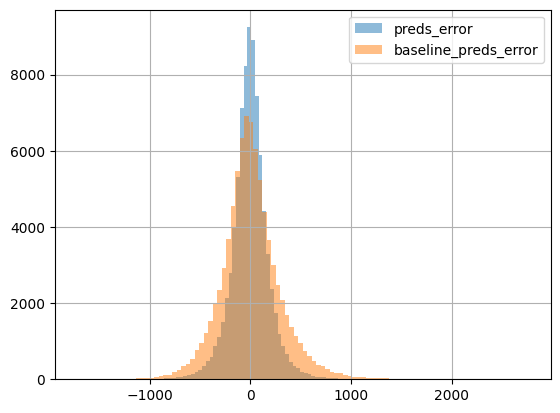

In [115]:
preds_error.hist(bins=100, alpha=0.5, legend=True)
baseline_preds_error.hist(bins=100, alpha=0.5, legend=True)

In [116]:
preds_error.quantile([0.025, 0.975])

0.025   -384.856696
0.975    377.976056
Name: preds_error, dtype: float64

In [117]:
baseline_preds_error.quantile([0.025, 0.975])

0.025   -565.667715
0.975    649.982855
Name: baseline_preds_error, dtype: float64

In [118]:
preds_percentage_error.quantile([0.025, 0.975])

0.025   -0.727354
0.975    0.310724
Name: preds_percentage_error, dtype: float64

In [119]:
baseline_preds_percentage_error.quantile([0.025, 0.975])

0.025   -1.122473
0.975    0.397185
Name: baseline_preds_percentage_error, dtype: float64

In [120]:
def paired_bootstrap_diff(y, yhat, ybase, metric, n=1000):
    diffs = []
    size = len(y)
    for _ in tqdm(range(n)):
        idx = np.random.choice(y.index, size)
        diffs.append(metric(y[idx], ybase[idx]) - metric(y[idx], yhat[idx]))
    diffs = np.array(diffs)
    return np.percentile(diffs, [2.5, 97.5])

In [121]:
paired_bootstrap_diff(y_test, preds, baseline_preds, root_mean_squared_error)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.16it/s]


array([107.42213934, 110.90381447])

In [122]:
paired_bootstrap_diff(y_test, preds, baseline_preds, mean_absolute_percentage_error)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.67it/s]


array([0.09733333, 0.10130812])

In [123]:
paired_bootstrap_diff(y_test, preds, baseline_preds, mean_absolute_error)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.93it/s]


array([82.22286236, 84.62729992])

**Вывод:** Распределение ошибок модели стало уже по сравнению с распределением ошибок baseline. Это подтверждается как графиками, так и квантилями распределения. Также при помощи бутстрэпа были проверены разницы метрик между моделью и baseline на уровне значимости 95%. Т.к. ни в одной из метрик 0 у нас не попадает в интервалы, то можно говорить о статистической значимости улучшения модели по сравнению с baseline решением.

Теперь посмотрим на то, на каких данных модель ошибается сильнее всего.

In [124]:
error_df = pd.DataFrame(
    {
        "preds_error": preds_error,
        "preds_percentage_error": preds_percentage_error,
        "tank_id": test_tank_ids,
    }
).join(
    premium_df[["tank_id", "nation", "tier", "type"]].set_index("tank_id"), on="tank_id"
)

In [125]:
error_df["null_share"] = X_test.isna().mean(axis=1)

In [126]:
error_df["target"] = y_test
error_df["preds"] = preds

In [127]:
error_df.tier.value_counts()

tier
8     22458
7     13002
6     10359
3      9329
5      9080
10     6862
4      5485
2      4534
9      2406
Name: count, dtype: int64

In [128]:
error_df[
    error_df.preds_error < error_df.preds_error.quantile(0.025)
].tier.value_counts()

tier
8     801
10    528
7     373
9     156
6     134
5      70
3      10
4      10
2       6
Name: count, dtype: int64

In [129]:
error_df[
    error_df.preds_error > error_df.preds_error.quantile(0.975)
].tier.value_counts()

tier
8     754
10    500
7     445
6     158
9     107
5      65
3      24
4      22
2      13
Name: count, dtype: int64

Как видим, как правило, рост абсолютной ошибки связан с ростом уровня техники, что вполне закономерно, т.к. с ростом уровня техники растет и урон, наносимый танками, и прочность самих танков. Поэтому лучше будем ориентироваться на процентную ошибку.

In [130]:
error_df[
    error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025)
].tier.value_counts()

tier
3     657
2     422
5     246
4     233
8     168
6     158
7     135
10     51
9      18
Name: count, dtype: int64

In [131]:
error_df[
    error_df.preds_percentage_error > error_df.preds_percentage_error.quantile(0.975)
].tier.value_counts()

tier
3     644
2     472
4     233
5     204
7     173
8     152
6     139
10     54
9      17
Name: count, dtype: int64

Как видим количество процентных ошибок, наоборот, уменьшаеатся с ростом уровня.

In [132]:
error_df[
    error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025)
].groupby("tier").null_share.mean()

tier
2     0.864124
3     0.852803
4     0.851870
5     0.824184
6     0.825482
7     0.795603
8     0.830054
9     0.923582
10    0.835906
Name: null_share, dtype: float64

In [133]:
error_df[
    error_df.preds_percentage_error > error_df.preds_percentage_error.quantile(0.975)
].groupby("tier").null_share.mean()

tier
2     0.866320
3     0.863019
4     0.850824
5     0.825295
6     0.797109
7     0.802792
8     0.854588
9     0.835015
10    0.795664
Name: null_share, dtype: float64

Как видим, доля отсутствующих значений приблизительно одинакова для каждого уровня. Посмотрим на ошибки в разрезе отдельных танков.

In [134]:
error_df[
    error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025)
].tank_id.value_counts()

tank_id
5665     68
4897     66
6433     53
56577    52
5121     52
         ..
19489     1
20737     1
21009     1
53025     1
9073      1
Name: count, Length: 233, dtype: int64

In [135]:
error_df[
    error_df.preds_percentage_error > error_df.preds_percentage_error.quantile(0.975)
].tank_id.value_counts()

tank_id
53537    67
5121     65
5665     64
4897     53
3601     53
         ..
19009     1
25089     1
24081     1
59905     1
21265     1
Name: count, Length: 230, dtype: int64

In [136]:
tanks_errors = error_df[
    (error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025))
    | (
        error_df.preds_percentage_error
        > error_df.preds_percentage_error.quantile(0.975)
    )
].tank_id.value_counts()

In [139]:
premium_df[premium_df.tank_id.isin(tanks_errors.head(20).index)]

,tank_id,nation,tier,type,name,default_profile.firepower,default_profile.hp,default_profile.hull_hp,default_profile.hull_weight,default_profile.maneuverability,...,default_profile.gun.move_up_arc,default_profile.gun.reload_time,default_profile.gun.traverse_speed,default_profile.suspension.load_limit,default_profile.suspension.traverse_speed,default_profile.turret.hp,default_profile.turret.traverse_left_arc,default_profile.turret.traverse_right_arc,default_profile.turret.traverse_speed,default_profile.turret.view_range
0,3073,ussr,3,lightTank,Т-46,21,480,384,7800,72,...,16,9.0,43.75,17300,48,96,180,180,44,220
10,53537,usa,2,lightTank,T1E6,11,390,312,5182,61,...,15,9.0,43.75,11100,42,78,180,180,38,210
15,5665,usa,2,mediumTank,T2 Medium Tank,12,400,320,6000,60,...,20,5.0,43.75,16200,41,80,180,180,36,230
53,2401,japan,3,lightTank,Type 98 Ke-Ni,25,480,384,2624,62,...,20,6.5,40.00,9500,44,96,180,180,36,220
74,51985,germany,3,mediumTank,Pz.Kpfw. S35 739 (f),19,490,392,10500,38,...,20,6.0,39.38,21300,40,98,180,180,41,230
80,52737,ussr,3,lightTank,М3 лёгкий,21,500,400,7100,64,...,25,3.5,43.75,12500,40,100,180,180,40,210
86,6433,usa,3,AT-SPG,T82,22,440,352,8750,59,...,27,12.0,40.25,15800,32,88,12,12,44,240
120,13329,germany,4,heavyTank,Durchbruchswagen 2,15,620,496,15250,28,...,20,12.5,40.25,33000,32,124,180,180,42,230
127,5121,ussr,2,AT-SPG,АТ-1,10,350,280,7050,43,...,23,9.0,43.75,10800,44,70,11,11,44,200
151,55073,usa,2,lightTank,T7 Combat Car,14,390,312,5085,64,...,40,8.5,43.75,12500,44,78,180,180,24,210


Как можно заметить, танки с наибольшим количеством сильных ошибок относятся к 2-4 уровням. С учетом этого, а также того, что, как правило, премиум-танки 2-4 уровнейне покупаются игроками самостоятельно, а получаются в качестве подарков в чемть каких-то праздников или выпадают случайно из контейнеров, и необходимо учитывать, что игроков, как правило, интересует высокоуровневая техника, то имеет смысл исключить танки этих уровней из предсказаний и из данных вообще, после чего переобучить модель с учетом этих правок.

## Анализ ошибок модели (2-ая итерация)

In [146]:
preds = predictor.predict(ag_test)

In [147]:
baseline_preds = test_tank_ids.map(avg_damage_dealt)

In [148]:
preds_error = y_test - preds
preds_error.name = "preds_error"
baseline_preds_error = y_test - baseline_preds
baseline_preds_error.name = "baseline_preds_error"
preds_percentage_error = preds_error / y_test
preds_percentage_error.name = "preds_percentage_error"
baseline_preds_percentage_error = baseline_preds_error / y_test
baseline_preds_percentage_error.name = "baseline_preds_percentage_error"

<Axes: >

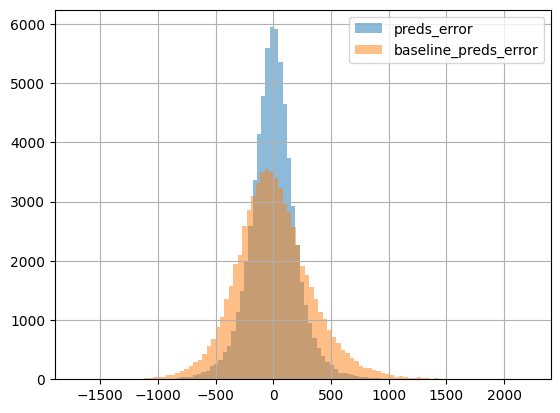

In [149]:
preds_error.hist(bins=100, alpha=0.5, legend=True)
baseline_preds_error.hist(bins=100, alpha=0.5, legend=True)

In [150]:
preds_error.quantile([0.025, 0.975])

0.025   -418.199854
0.975    421.076672
Name: preds_error, dtype: float64

In [151]:
baseline_preds_error.quantile([0.025, 0.975])

0.025   -613.509229
0.975    719.555652
Name: baseline_preds_error, dtype: float64

In [152]:
preds_percentage_error.quantile([0.025, 0.975])

0.025   -0.522774
0.975    0.266034
Name: preds_percentage_error, dtype: float64

In [153]:
baseline_preds_percentage_error.quantile([0.025, 0.975])

0.025   -0.921416
0.975    0.370361
Name: baseline_preds_percentage_error, dtype: float64

In [133]:
def paired_bootstrap_diff(y, yhat, ybase, metric, n=1000):
    diffs = []
    size = len(y)
    for _ in tqdm(range(n)):
        idx = np.random.choice(y.index, size)
        diffs.append(metric(y[idx], ybase[idx]) - metric(y[idx], yhat[idx]))
    diffs = np.array(diffs)
    return np.percentile(diffs, [2.5, 97.5])

In [134]:
paired_bootstrap_diff(y_test, preds, baseline_preds, root_mean_squared_error)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.68it/s]


array([123.92061612, 128.52729271])

In [135]:
paired_bootstrap_diff(y_test, preds, baseline_preds, mean_absolute_percentage_error)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.49it/s]


array([0.09611438, 0.09938505])

In [136]:
paired_bootstrap_diff(y_test, preds, baseline_preds, mean_absolute_error)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.84it/s]


array([100.66518035, 103.73611318])

**Вывод:** Распределение ошибок модели стало уже по сравнению с распределением ошибок baseline. Это подтверждается как графиками, так и квантилями распределения. Также при помощи бутстрэпа были проверены разницы метрик между моделью и baseline на уровне значимости 95%. Т.к. ни в одной из метрик 0 у нас не попадает в интервалы, то можно говорить о статистической значимости улучшения модели по сравнению с baseline решением.

In [114]:
error_df = pd.DataFrame(
    {
        "preds_error": preds_error,
        "preds_percentage_error": preds_percentage_error,
        "tank_id": test_tank_ids,
    }
).join(
    premium_df[["tank_id", "nation", "tier", "type"]].set_index("tank_id"), on="tank_id"
)

In [115]:
error_df["null_share"] = X_test.isna().mean(axis=1)

In [116]:
error_df["target"] = y_test
error_df["preds"] = preds

In [117]:
error_df.tier.value_counts()

tier
8     23204
7     13388
6     10578
5      9214
10     7069
9      2456
Name: count, dtype: int64

In [120]:
error_df[
    error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025)
].tier.value_counts()

tier
5     464
8     377
7     356
6     290
10    121
9      40
Name: count, dtype: int64

In [121]:
error_df[
    error_df.preds_percentage_error > error_df.preds_percentage_error.quantile(0.975)
].tier.value_counts()

tier
5     484
8     378
7     333
6     289
10    132
9      32
Name: count, dtype: int64

Как видим количество процентных ошибок, наоборот, уменьшаеатся с ростом уровня.

In [122]:
error_df[
    error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025)
].groupby("tier").null_share.mean()

tier
5     0.796110
6     0.751034
7     0.785742
8     0.783342
9     0.814905
10    0.782529
Name: null_share, dtype: float64

In [123]:
error_df[
    error_df.preds_percentage_error > error_df.preds_percentage_error.quantile(0.975)
].groupby("tier").null_share.mean()

tier
5     0.788205
6     0.774589
7     0.757622
8     0.782811
9     0.754872
10    0.785642
Name: null_share, dtype: float64

Как видим, доля отсутствующих значений приблизительно одинакова для каждого уровня. Посмотрим на ошибки в разрезе отдельных танков.

In [124]:
error_df[
    error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025)
].tank_id.value_counts()

tank_id
2577     63
11265    45
53761    34
7537     32
10529    29
         ..
1393      1
8305      1
24081     1
25889     1
19009     1
Name: count, Length: 203, dtype: int64

In [125]:
error_df[
    error_df.preds_percentage_error > error_df.preds_percentage_error.quantile(0.975)
].tank_id.value_counts()

tank_id
7537     44
51713    36
10529    33
2577     33
5489     29
         ..
22049     1
21585     1
7793      1
113       1
1393      1
Name: count, Length: 203, dtype: int64

In [126]:
tanks_errors = error_df[
    (error_df.preds_percentage_error < error_df.preds_percentage_error.quantile(0.025))
    | (
        error_df.preds_percentage_error
        > error_df.preds_percentage_error.quantile(0.975)
    )
].tank_id.value_counts()

In [127]:
premium_df[premium_df.tank_id.isin(tanks_errors.head(20).index)]

,tank_id,nation,tier,type,name,default_profile.firepower,default_profile.hp,default_profile.hull_hp,default_profile.hull_weight,default_profile.maneuverability,...,default_profile.gun.move_up_arc,default_profile.gun.reload_time,default_profile.gun.traverse_speed,default_profile.suspension.load_limit,default_profile.suspension.traverse_speed,default_profile.turret.hp,default_profile.turret.traverse_left_arc,default_profile.turret.traverse_right_arc,default_profile.turret.traverse_speed,default_profile.turret.view_range
39,625,other,6,mediumTank,Stridsvagn 74A2,48,950,760,12600,48,...,9,13.00,43.75,31000,40,190,180,180,48,250
49,11265,ussr,6,heavyTank,Т-150,34,1200,960,30200,28,...,20,14.20,26.25,58800,24,240,180,180,20,230
54,64529,germany,7,AT-SPG,E 25,100,1000,800,14700,76,...,15,3.50,35.00,29000,44,200,12,12,44,240
77,51713,ussr,5,heavyTank,Черчилль III,38,840,672,20869,16,...,12,3.64,43.75,41950,20,168,180,180,20,240
87,53761,ussr,5,AT-SPG,СУ-85И,47,670,536,13120,52,...,25,6.80,39.38,24380,48,134,10,10,44,230
92,54785,ussr,6,AT-SPG,СУ-100Y,40,900,720,42603,34,...,15,17.70,26.25,67400,30,180,10,10,26,240
93,8753,china,7,lightTank,M41D,71,1200,1020,11662,94,...,18,4.00,40.25,28000,57,180,180,180,50,250
94,23041,ussr,5,mediumTank,Т-34 экранированный,30,720,568,17180,51,...,17,7.80,39.38,34000,45,152,180,180,36,230
103,10529,usa,5,AT-SPG,T67,37,550,400,7000,59,...,20,6.80,40.25,16400,32,150,180,180,18,230
108,64337,uk,6,mediumTank,AC IV Sentinel,41,970,776,14600,56,...,20,6.10,40.25,36000,44,194,180,180,38,240


Как можно заметить, на данной итерации танки с наибольшими ошибками отличаются между собой как по уровню, так и по нации и типу техники, а значит можно говорить о естественном шуме и, возможно, увеличение объема данных помогло бы уменьшить размер ошибок.